In [107]:
res_dir <- "analysis_results"
system(paste("mkdir -p ", res_dir))

library(ggplot2)
library(dplyr)
library(tidyverse)
library(SPRING)
library(RColorBrewer)
library(patchwork)
library(car)
library(ggpubr)
library(rstatix)
library("Hmisc")
library("corrplot")
library(outliers)

In [108]:
# ggplot theme #
my_theme0 <- theme(panel.background = element_rect(fill = "transparent", 
                                                colour = NA), plot.background = element_rect(colour = 'NA', 
                                                                                             fill = 'transparent'),panel.grid.major=element_line(color=NA),
                axis.line=element_line(size=1.2,color="black"),
                axis.ticks=element_line(color="black"),
                axis.text=element_text(color="black",size=26),
                axis.title=element_text(color="black",size=30),
                panel.grid.minor = element_line(colour = NA),
                legend.text=element_text(size=17),legend.key=element_rect(fill="white"),
                legend.title=element_text(size=18,face="bold"),
                axis.text.x=element_text(angle=60,size=26,vjust=0.5),
                panel.border = element_rect(colour = "black", fill=NA, size=1),
                legend.position = "none")

my_theme1 <- theme_bw() + 
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=18, color="black"), 
        axis.title.y = element_text(size=18, color="black"), 
        axis.text.x = element_text(angle = 0, hjust = 1, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=10), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm")
       ) 

### - read in percentage and metadata files

In [109]:
kaiju_relpct_file <- "kaiju__MERGED_min_2000_pct.tsv"
metaeuk_relpct_file <- "metaeuk__MERGED_min_2000_pct.tsv"
def_relpct_file <- "DEF__MERGED_min_2000_pct.tsv"
metadata_file <- "ESPAE_metadata_CTD.tsv"
contig2type_file <- "contig2type.tsv"

kaiju_relpct_df <- read.table(kaiju_relpct_file, header = T, sep = "\t", as.is = T, stringsAsFactors = F, row.names = 1)
metaeuk_relpct_df <- read.table(metaeuk_relpct_file, header = T, sep = "\t", as.is = T, stringsAsFactors = F, row.names = 1)
def_relpct_df <- read.table(def_relpct_file, header = T, sep = "\t", as.is = T, stringsAsFactors = F, row.names = 1)
metadata_df <- read.table(metadata_file, header=T, sep="\t", as.is=T, stringsAsFactors = F, row.names = 1)
contig2type_df <- read.table(contig2type_file, header = T, sep = "\t", as.is=T, stringsAsFactors = F, row.names=1)
head(kaiju_relpct_df, 2)
head(metadata_df, 2)
colnames(metadata_df)

,Eukaryote,EukaryoticVirus,Prokaryote,ProkaryoticVirus,Unclassified,UnclassifiedVirus,TotalCnt
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
ESPAEMG01_S37_L003,22.04348,0.8152525,52.23363,3.561932,20.64605,0.6996461,38832631
ESPAEMG02_S38_L003,19.94248,0.7910602,54.45902,3.322740,20.80867,0.6760222,34578152


,Library_Type,Filter_Fraction,Month_Day,Month,Day,Time,Temperature,Depth,Salinity,Chlorophyll,Transmission,Total_Reads
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
ESPAEMG01_S37_L003,MG,AE,Mar_18,3,18,AM,16.14,9.740,33.447,0.40,94.1,81077508
ESPAEMG02_S38_L003,MG,AE,Mar_19,3,19,AM,16.25,8.625,33.447,0.82,95.1,69411938


[1] "Library_Type"    "Filter_Fraction" "Month_Day"       "Month"          
 [5] "Day"             "Time"            "Temperature"     "Depth"          
 [9] "Salinity"        "Chlorophyll"     "Transmission"    "Total_Reads"

In [110]:
head(contig2type_df, 2)
nrow(contig2type_df)

,DEF_Class,Kaiju_Class,MetaEuk_Class
,<chr>,<chr>,<chr>
ESP_1,Prokaryote,Prokaryote,Prokaryote
ESP_2,Prokaryote,Prokaryote,Prokaryote


[1] 331357

In [111]:
DEF_cnt <- contig2type_df %>%
    count(DEF_Class)
Kaiju_cnt <- contig2type_df %>%
    count(Kaiju_Class)
MetaEuk_cnt <- contig2type_df %>%
    count(MetaEuk_Class)
type_cnt_df <- data.frame(row.names = c("Eukaryote", "EukaryoteVirus", "Prokaryote", "ProkaryoteVirus", "Unclassified", "UnclassifiedVirus"))
type_cnt_df$DeepMicrobeFinder = c(DEF_cnt$n, 0, 0)
type_cnt_df$Kaiju = c(Kaiju_cnt$n)
type_cnt_df$MetaEuk = c(MetaEuk_cnt$n)
type_cnt_df.long <- type_cnt_df %>% 
    rownames_to_column(var = "SeqType") %>% 
    gather(key = Predictor, value = Count, -SeqType) %>% 
    group_by(Predictor) %>% 
    mutate(Percentage = Count / sum(Count) * 100) %>%
    mutate(SeqType = factor(SeqType, levels=c("Prokaryote", "ProkaryoteVirus", "Eukaryote", "EukaryoteVirus", "Unclassified", "UnclassifiedVirus"))) 

head(type_cnt_df.long, 5)

SeqType,Predictor,Count,Percentage
<fct>,<chr>,<dbl>,<dbl>
Eukaryote,DeepMicrobeFinder,97658,29.47214
EukaryoteVirus,DeepMicrobeFinder,13603,4.10524
Prokaryote,DeepMicrobeFinder,169290,51.08991
ProkaryoteVirus,DeepMicrobeFinder,50806,15.33271
Unclassified,DeepMicrobeFinder,0,0.00000


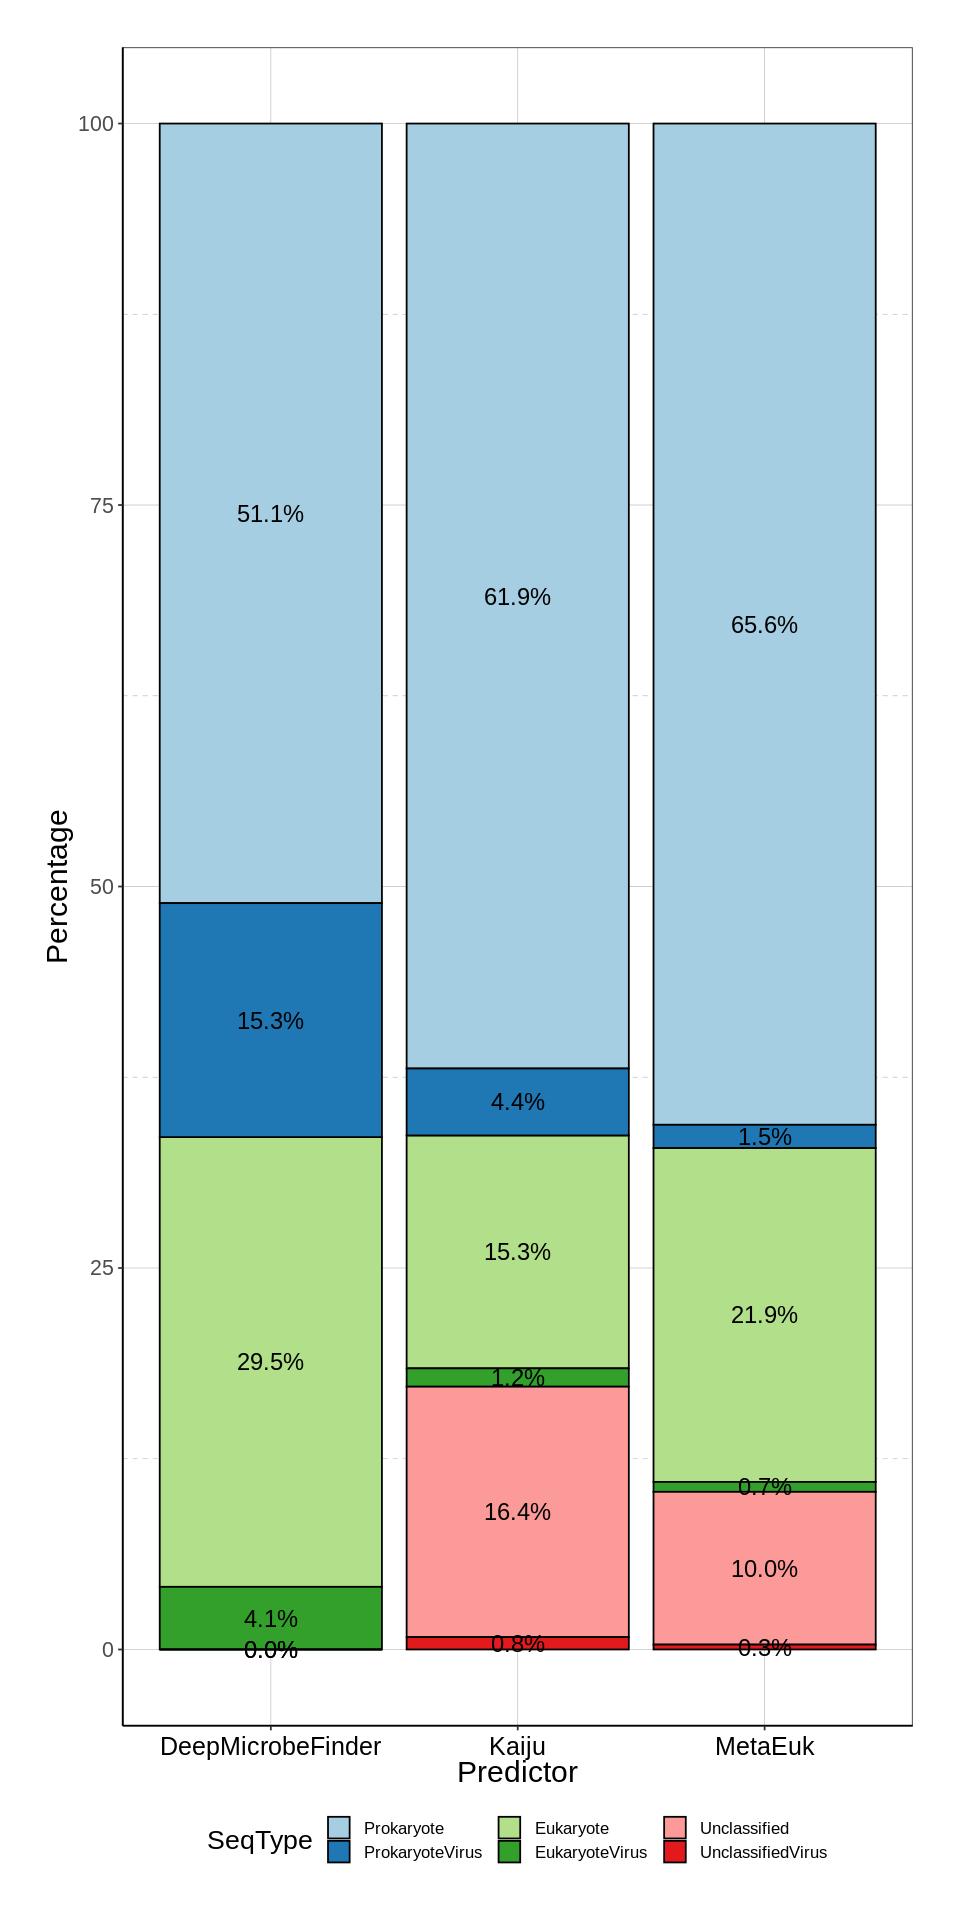

In [112]:
options(repr.plot.width=8, repr.plot.height=16)

p_bar <- ggplot(type_cnt_df.long, aes(fill=SeqType, y=Percentage, x=Predictor)) + 
  geom_bar(position="stack", stat="identity", color="black", size=0.5) +
  geom_text(aes(label=sprintf("%.1f%%", Percentage)), position=position_stack(vjust=0.5), size=5, color="black") +
  scale_fill_brewer(palette="Paired") + 
  my_theme1 +
  theme(axis.text.x=element_text(size=15, angle=0, hjust=0.5, vjust=0.3))
p_bar

ggsave(filename="ESPAE_kaiju_metaeuk_DEF_bwa_percentage_plot_2k_SeqType.pdf", useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 160, height = 320, units = "mm",
       dpi = 300, limitsize = FALSE)

In [113]:
type_cnt_df <- contig2type_df %>%
    count(DEF_Class, Kaiju_Class, MetaEuk_Class, sort=TRUE)
head(type_cnt_df, 2)

,DEF_Class,Kaiju_Class,MetaEuk_Class,n
,<chr>,<chr>,<chr>,<int>
1,Prokaryote,Prokaryote,Prokaryote,155761
2,Eukaryote,Eukaryote,Eukaryote,45980


In [114]:
sum(type_cnt_df$n)

[1] 331357

In [115]:
table(contig2type_df$DEF_Class)


      Eukaryote  EukaryoteVirus      Prokaryote ProkaryoteVirus 
          97658           13603          169290           50806 

### - what are the kaiju and metaeuk unclassified contigs 

In [116]:
kaiju_uncl_df <- contig2type_df[which(contig2type_df$Kaiju_Class == "Unclassified"), c("DEF_Class"), drop=F]
metaeuk_uncl_df <- contig2type_df[which(contig2type_df$MetaEuk_Class == "Unclassified"), c("DEF_Class"), drop=F]
head(metaeuk_uncl_df, 2)

,DEF_Class
,<chr>
ESP_42,ProkaryoteVirus
ESP_76,Prokaryote


In [117]:
kaiju_uncl_df <- contig2type_df %>% 
    filter(Kaiju_Class == "Unclassified") %>% 
    select(DEF_Class) %>% 
    group_by(DEF_Class) %>% 
    summarise(Count = n()) %>% 
    mutate(Fraction=Count/sum(Count)) %>% 
    mutate(DEF_Class = factor(DEF_Class, levels=c("Prokaryote", "ProkaryoteVirus", "Eukaryote", "EukaryoteVirus")))
# Compute the cumulative percentages (top of each rectangle)
kaiju_uncl_df$ymax <- cumsum(kaiju_uncl_df$Fraction)
# Compute the bottom of each rectangle
kaiju_uncl_df$ymin <- c(0, head(kaiju_uncl_df$ymax, n=-1))
# Compute label position
kaiju_uncl_df$labelPosition <- (kaiju_uncl_df$ymax + kaiju_uncl_df$ymin) / 2
# Compute a good label
kaiju_uncl_df$label <- paste0(kaiju_uncl_df$DEF_Class, "\n", round(100*kaiju_uncl_df$Fraction, digits=2), "%")
head(kaiju_uncl_df)

DEF_Class,Count,Fraction,ymax,ymin,labelPosition,label
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Eukaryote,32503,0.5976464,0.5976464,0.0000000,0.2988232,Eukaryote 59.76%
EukaryoteVirus,6368,0.1170911,0.7147375,0.5976464,0.6561920,EukaryoteVirus 11.71%
Prokaryote,6094,0.1120530,0.8267905,0.7147375,0.7707640,Prokaryote 11.21%
ProkaryoteVirus,9420,0.1732095,1.0000000,0.8267905,0.9133952,ProkaryoteVirus 17.32%


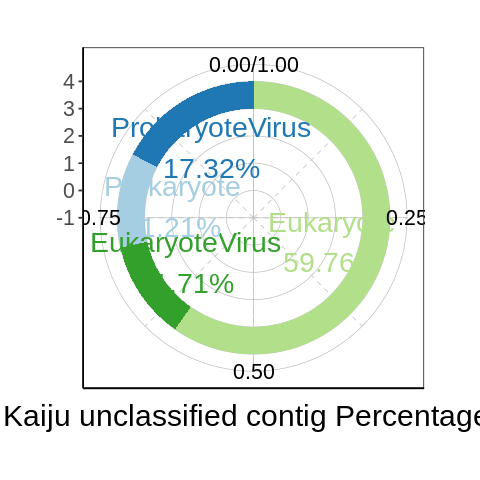

In [118]:
options(repr.plot.width=4, repr.plot.height=4)
# Make the plot
p_kaiju_uncl <- ggplot(kaiju_uncl_df, aes(ymax=ymax, ymin=ymin, xmax=4, xmin=3, fill=DEF_Class)) +
  geom_rect() +
  geom_text( x=2, aes(y=labelPosition, label=label, color=DEF_Class), size=6) + # x here controls label position (inner / outer)
  coord_polar(theta="y") +
  xlim(c(-1, 4)) +
  scale_fill_brewer(palette="Paired") + scale_color_brewer(palette="Paired") +
  my_theme1 + labs(y="Kaiju unclassified contig Percentages") +
  theme(legend.position = "none")
p_kaiju_uncl

In [119]:
metaeuk_uncl_df <- contig2type_df %>% 
    filter(MetaEuk_Class == "Unclassified") %>% 
    select(DEF_Class) %>% 
    group_by(DEF_Class) %>% 
    summarise(Count = n()) %>% 
    mutate(Fraction=Count/sum(Count)) %>% 
    mutate(DEF_Class = factor(DEF_Class, levels=c("Prokaryote", "ProkaryoteVirus", "Eukaryote", "EukaryoteVirus")))

# Compute the cumulative percentages (top of each rectangle)
metaeuk_uncl_df$ymax <- cumsum(metaeuk_uncl_df$Fraction)
# Compute the bottom of each rectangle
metaeuk_uncl_df$ymin <- c(0, head(metaeuk_uncl_df$ymax, n=-1))
# Compute label position
metaeuk_uncl_df$labelPosition <- (metaeuk_uncl_df$ymax + metaeuk_uncl_df$ymin) / 2
# Compute a good label
metaeuk_uncl_df$label <- paste0(metaeuk_uncl_df$DEF_Class, "\n", round(100*metaeuk_uncl_df$Fraction, digits=2), "%")
head(metaeuk_uncl_df)

DEF_Class,Count,Fraction,ymax,ymin,labelPosition,label
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Eukaryote,12604,0.3799934,0.3799934,0.0000000,0.1899967,Eukaryote 38%
EukaryoteVirus,4450,0.1341614,0.5141548,0.3799934,0.4470741,EukaryoteVirus 13.42%
Prokaryote,4954,0.1493563,0.6635111,0.5141548,0.5888329,Prokaryote 14.94%
ProkaryoteVirus,11161,0.3364889,1.0000000,0.6635111,0.8317556,ProkaryoteVirus 33.65%


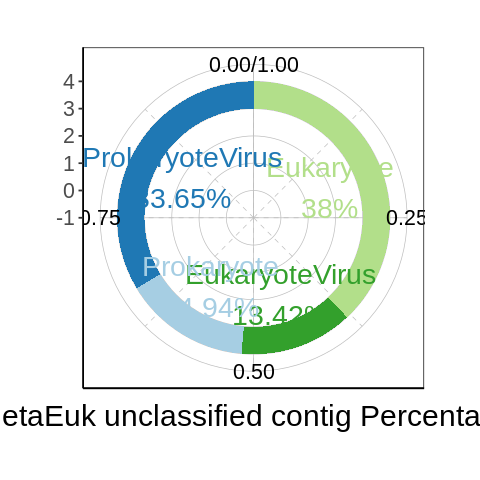

In [120]:
options(repr.plot.width=4, repr.plot.height=4)
# Make the plot
p_metaeuk_uncl <- ggplot(metaeuk_uncl_df, aes(ymax=ymax, ymin=ymin, xmax=4, xmin=3, fill=DEF_Class)) +
  geom_rect() +
  geom_text( x=2, aes(y=labelPosition, label=label, color=DEF_Class), size=6) + # x here controls label position (inner / outer)
  coord_polar(theta="y") +
  xlim(c(-1, 4)) +
  scale_fill_brewer(palette="Paired") + scale_color_brewer(palette="Paired") +
  my_theme1 + labs(y="MetaEuk unclassified contig Percentages") +
  theme(legend.position = "none")
p_metaeuk_uncl

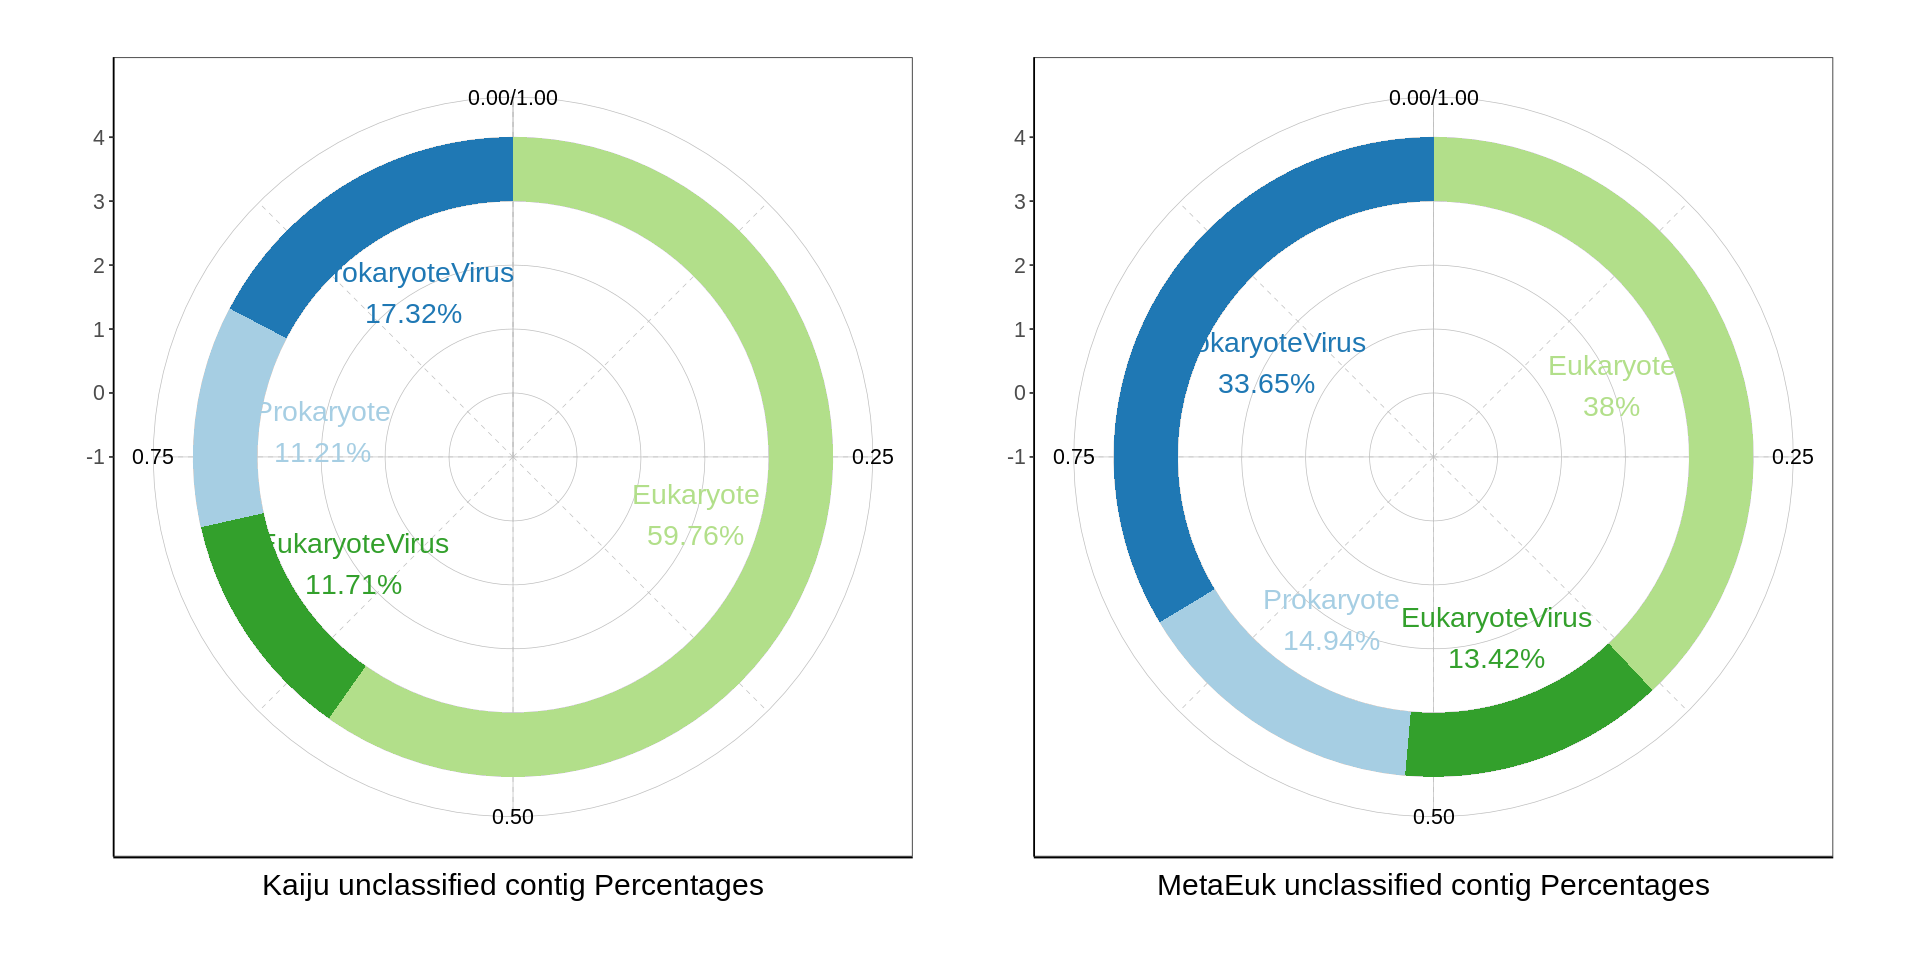

In [121]:
options(repr.plot.width=16, repr.plot.height=8)
p_kaiju_uncl + p_metaeuk_uncl

ggsave(filename="ESPAE_kaiju_metaeuk_DEF_bwa_percentage_plot_2k_unclassified.pdf", useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 320, height = 160, units = "mm",
       dpi = 300, limitsize = FALSE)

### - what are prokaryotes classified by both kaiju and metaeuk?

In [122]:
kaiju_metaeuk_prok_df <- contig2type_df[which(contig2type_df$Kaiju_Class == "Prokaryote" & contig2type_df$MetaEuk_Class == "Prokaryote"), c("DEF_Class"), drop=F]
head(kaiju_metaeuk_prok_df, 2)
nrow(kaiju_metaeuk_prok_df)
table(kaiju_metaeuk_prok_df)

,DEF_Class
,<chr>
ESP_1,Prokaryote
ESP_2,Prokaryote


[1] 194549

kaiju_metaeuk_prok_df
      Eukaryote  EukaryoteVirus      Prokaryote ProkaryoteVirus 
          16000            1928          155761           20860 

In [123]:
kaiju_metaeuk_prok_df <- contig2type_df %>% 
    filter(Kaiju_Class == "Prokaryote" & MetaEuk_Class == "Prokaryote") %>% 
    select(DEF_Class) %>% 
    group_by(DEF_Class) %>% 
    summarise(Count = n()) %>% 
    mutate(Fraction=Count/sum(Count)) %>% 
    mutate(DEF_Class = factor(DEF_Class, levels=c("Prokaryote", "ProkaryoteVirus", "Eukaryote", "EukaryoteVirus")))

# Compute the cumulative percentages (top of each rectangle)
kaiju_metaeuk_prok_df$ymax <- cumsum(kaiju_metaeuk_prok_df$Fraction)
# Compute the bottom of each rectangle
kaiju_metaeuk_prok_df$ymin <- c(0, head(kaiju_metaeuk_prok_df$ymax, n=-1))
# Compute label position
kaiju_metaeuk_prok_df$labelPosition <- (kaiju_metaeuk_prok_df$ymax + kaiju_metaeuk_prok_df$ymin) / 2
# Compute a good label
kaiju_metaeuk_prok_df$label <- paste0(kaiju_metaeuk_prok_df$DEF_Class, "\n", round(100*kaiju_metaeuk_prok_df$Fraction, digits=2), "%")
head(kaiju_metaeuk_prok_df)


DEF_Class,Count,Fraction,ymax,ymin,labelPosition,label
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Eukaryote,16000,0.08224149,0.08224149,0.00000000,0.04112075,Eukaryote 8.22%
EukaryoteVirus,1928,0.00991010,0.09215159,0.08224149,0.08719654,EukaryoteVirus 0.99%
Prokaryote,155761,0.80062606,0.89277765,0.09215159,0.49246462,Prokaryote 80.06%
ProkaryoteVirus,20860,0.10722235,1.00000000,0.89277765,0.94638883,ProkaryoteVirus 10.72%


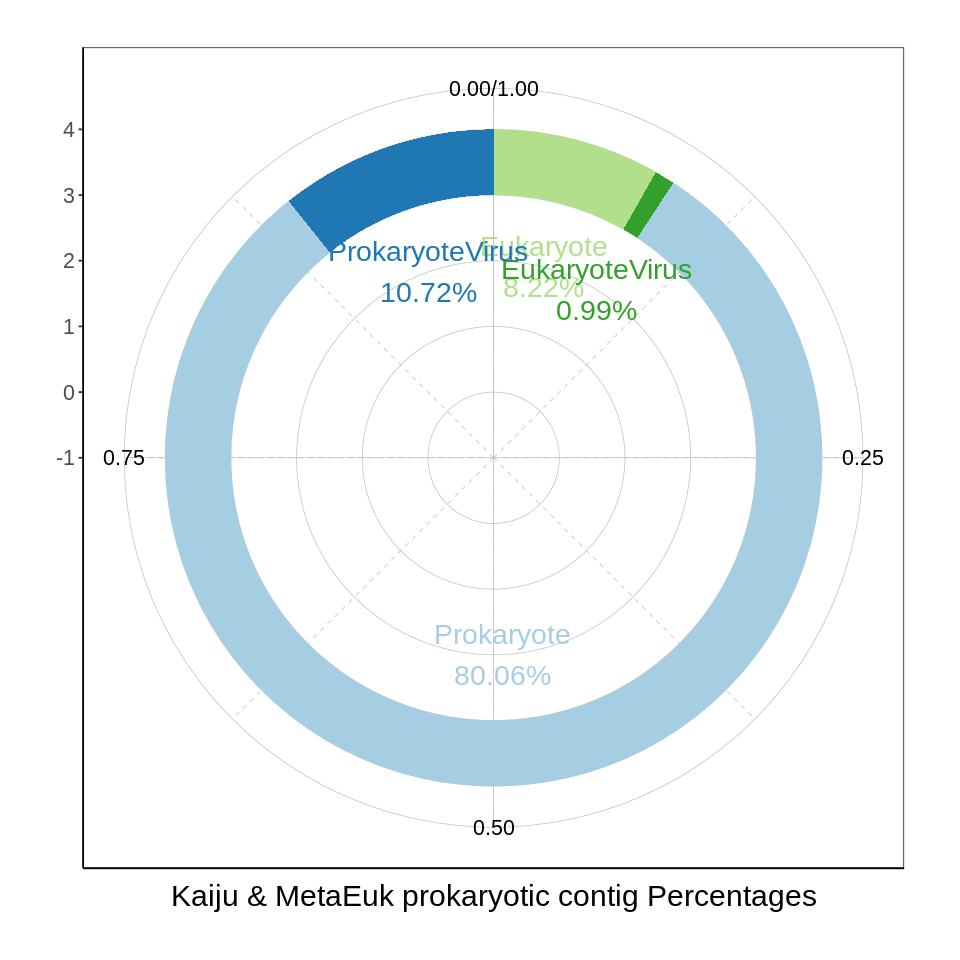

In [124]:
options(repr.plot.width=8, repr.plot.height=8)
# Make the plot
p_kaiju_metaeuk_prok <- ggplot(kaiju_metaeuk_prok_df, aes(ymax=ymax, ymin=ymin, xmax=4, xmin=3, fill=DEF_Class)) +
  geom_rect() +
  geom_text( x=2, aes(y=labelPosition, label=label, color=DEF_Class), size=6) + # x here controls label position (inner / outer)
  coord_polar(theta="y") +
  xlim(c(-1, 4)) +
  scale_fill_brewer(palette="Paired") + scale_color_brewer(palette="Paired") +
  my_theme1 + labs(y="Kaiju & MetaEuk prokaryotic contig Percentages") +
  theme(legend.position = "none")
p_kaiju_metaeuk_prok

ggsave(filename="ESPAE_kaiju_metaeuk_DEF_bwa_percentage_plot_2k_KaijuMetaEukProk.pdf", useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 320, height = 160, units = "mm",
       dpi = 300, limitsize = FALSE)

### - calculate and plot mapped read ratios 

In [125]:
map_glbpct_df <- metadata_df[, c("Month_Day", "Total_Reads")]
map_glbpct_df[, "MappedRatio"] <-  100 * def_relpct_df$TotalCnt / map_glbpct_df$Total_Reads
head(map_glbpct_df,2)

,Month_Day,Total_Reads,MappedRatio
,<chr>,<int>,<dbl>
ESPAEMG01_S37_L003,Mar_18,81077508,12.49829
ESPAEMG02_S38_L003,Mar_19,69411938,13.97524


In [126]:
map_glbpct_df$Month_Day

[1] "Mar_18" "Mar_19" "Mar_20" "Mar_21" "Mar_22" "Mar_23" "Apr_08" "Apr_09"
 [9] "Apr_10" "Apr_11" "Apr_12" "Apr_13" "Apr_14" "Apr_15" "Apr_16" "Apr_17"
[17] "Apr_18" "Apr_19" "Apr_20" "Apr_21" "Apr_22" "Apr_23" "Apr_24" "Apr_25"
[25] "Apr_26" "Apr_27" "Apr_28" "Apr_30" "May_01"

,Month_Day,Total_Reads,MappedRatio
,<fct>,<int>,<dbl>
ESPAEMG01_S37_L003,Mar_18,81077508,12.49829
ESPAEMG02_S38_L003,Mar_19,69411938,13.97524


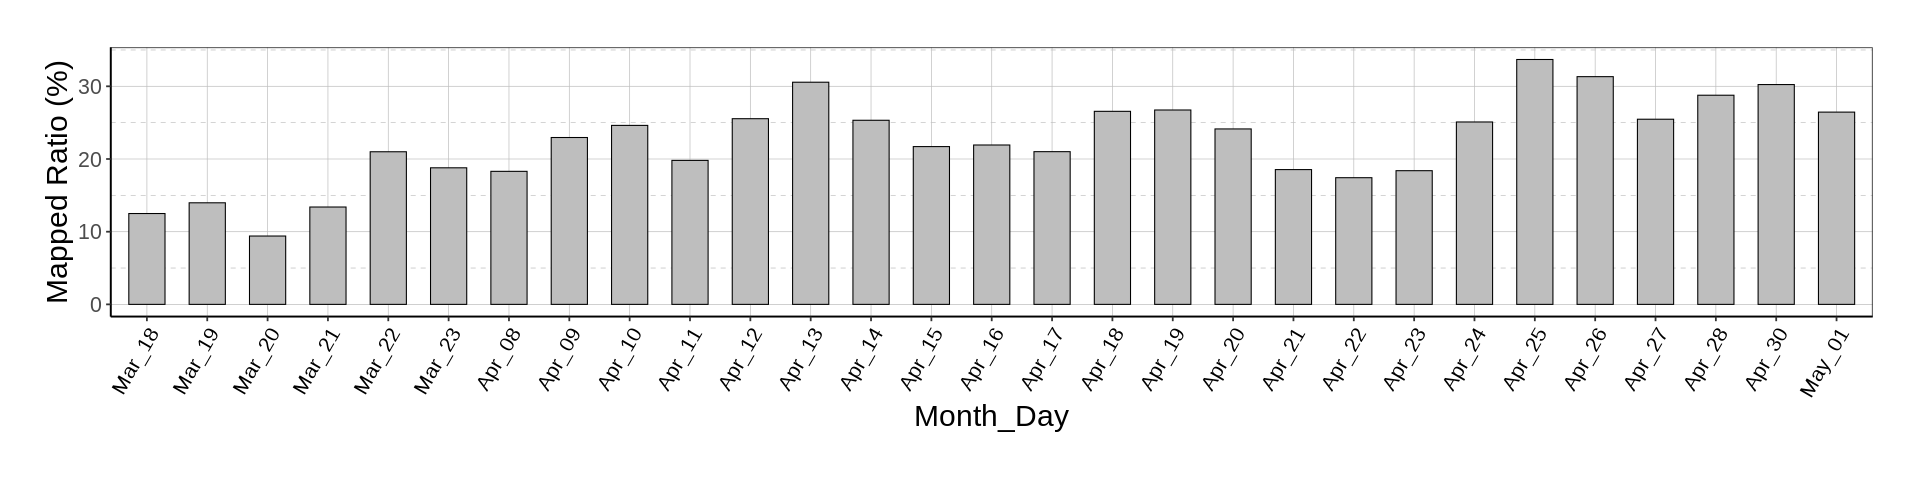

In [127]:
options(repr.plot.width=16, repr.plot.height=4)

# select columns to plot map ratio for 2k
Date_order <- map_glbpct_df$Month_Day
map_glbpct_df <- map_glbpct_df %>% 
  mutate(Month_Day = factor(Month_Day, levels=Date_order)) %>%
  select(Month_Day, Total_Reads, MappedRatio)
head(map_glbpct_df, 2)

# plot map ratio
p_map_ratio <- ggplot(data=map_glbpct_df) + 
  geom_bar(mapping=aes(x=Month_Day, y=MappedRatio), 
           position=position_dodge(.6), width=0.6, stat="identity", colour="black", fill="gray", size=.3) + 
  scale_y_continuous(minor_breaks = seq(0, 100, 5), breaks = seq(0, 100, 10)) +
  labs(y="Mapped Ratio (%)") + 
  my_theme1 + theme(axis.text.x=element_text(angle=60,vjust=1))
p_map_ratio

In [128]:
head(def_relpct_df)
head(metadata_df)

,Eukaryote,EukaryoteVirus,Plasmid,Prokaryote,ProkaryoteVirus,TotalCnt
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
ESPAEMG01_S37_L003,24.64725,3.925888,8.904819,39.23969,23.28235,10133300
ESPAEMG02_S38_L003,23.30869,4.408048,9.213087,45.04093,18.02924,9700484
ESPAEMG03_S39_L003,22.71188,5.819888,14.489189,33.88442,23.09462,8899518
ESPAEMG04_S40_L003,35.63565,2.794289,6.291173,30.91469,24.36420,10874538
ESPAEMG05_S41_L003,42.20726,1.510810,7.822052,36.63370,11.82618,15656634
ESPAEMG06_S42_L003,34.37904,1.736908,8.533437,39.60061,15.75000,18632188


,Library_Type,Filter_Fraction,Month_Day,Month,Day,Time,Temperature,Depth,Salinity,Chlorophyll,Transmission,Total_Reads
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
ESPAEMG01_S37_L003,MG,AE,Mar_18,3,18,AM,16.140,9.740,33.447,0.40,94.1,81077508
ESPAEMG02_S38_L003,MG,AE,Mar_19,3,19,AM,16.250,8.625,33.447,0.82,95.1,69411938
ESPAEMG03_S39_L003,MG,AE,Mar_20,3,20,AM,16.283,4.689,33.448,0.54,94.6,94646542
ESPAEMG04_S40_L003,MG,AE,Mar_21,3,21,AM,16.597,3.929,33.489,0.65,94.8,81187940
ESPAEMG05_S41_L003,MG,AE,Mar_22,3,22,AM,16.652,3.259,33.524,0.68,95.9,74567740
ESPAEMG06_S42_L003,MG,AE,Mar_23,3,23,AM,16.559,3.306,33.523,0.78,94.8,99165690


### - plot DeepMicrobeFinder class percentages of all reads (global percentages)

$GlobalPercentage = 100 * \dfrac{MappedReads * \dfrac{RelativePercentage}{100}}{AllReads} = MappedReads * \dfrac{RelativePercentage}{AllReads}$

In [129]:
def_glbpct_meta_df <- subset(def_relpct_df, select=-c(TotalCnt))
def_glbpct_meta_df <- def_glbpct_meta_df * def_relpct_df$TotalCnt / metadata_df$Total_Reads
def_glbpct_meta_df["Month_Day"] <- metadata_df[, c("Month_Day")]
head(def_glbpct_meta_df, 2)

,Eukaryote,EukaryoteVirus,Plasmid,Prokaryote,ProkaryoteVirus,Month_Day
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ESPAEMG01_S37_L003,3.080484,0.4906688,1.112950,4.904290,2.909895,Mar_18
ESPAEMG02_S38_L003,3.257445,0.6160352,1.287551,6.294577,2.519630,Mar_19


In [130]:
def_glbpct_meta_df.long <- def_glbpct_meta_df %>% 
  mutate(Month_Day = factor(Month_Day, levels=Date_order)) %>% 
  mutate(ProkPlas = Plasmid + Prokaryote) %>% 
  #select(Month_Day, Eukaryote, EukaryoteVirus, Plasmid, Prokaryote, ProkaryoteVirus) %>% 
  select(Month_Day, Eukaryote, EukaryoteVirus, ProkPlas, ProkaryoteVirus) %>% 
  gather(Eukaryote:ProkaryoteVirus, key="Seq_Class", value="Percentage") %>% 
  #mutate(Seq_Class = factor(Seq_Class, levels=c("Prokaryote", "ProkaryoteVirus", "Eukaryote", "EukaryoteVirus", "Plasmid"))) 
  mutate(Seq_Class = factor(Seq_Class, levels=c("ProkPlas", "ProkaryoteVirus", "Eukaryote", "EukaryoteVirus"))) 

head(def_glbpct_meta_df.long, 2)

,Month_Day,Seq_Class,Percentage
,<fct>,<fct>,<dbl>
1,Mar_18,Eukaryote,3.080484
2,Mar_19,Eukaryote,3.257445


,xmin,xmax
,<dbl>,<dbl>
1,1.5,2.5
2,3.5,4.5


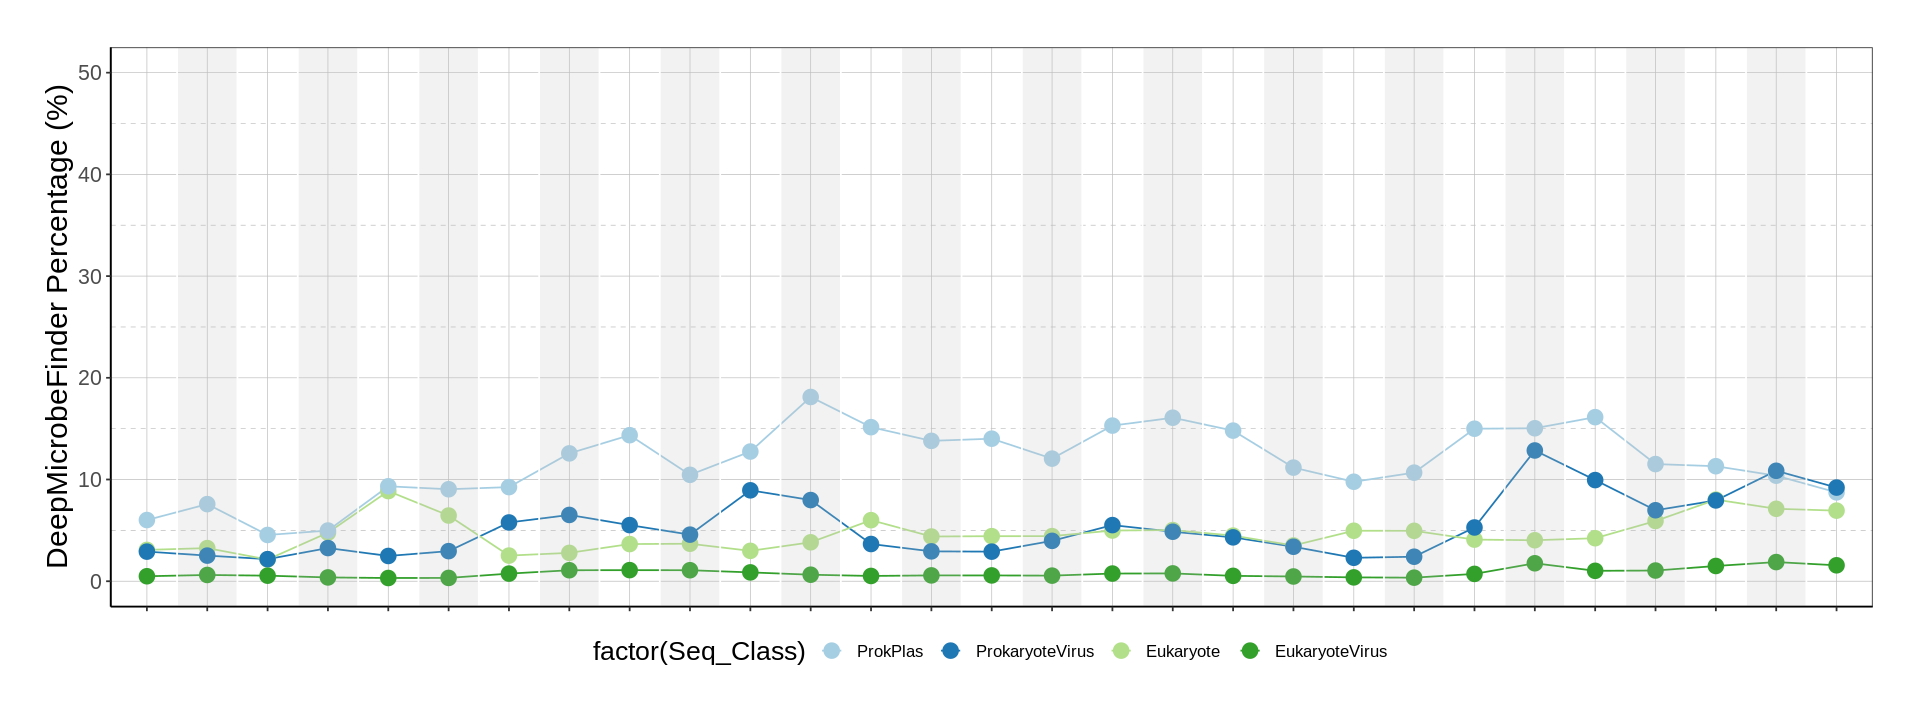

In [131]:
options(repr.plot.width=16, repr.plot.height=6)

# rects
rects <- data.frame(xmin = seq(1.5, 28.5, 2), 
                    xmax = seq(2.5, 29.5, 2))
head(rects, 2)

# plot with rects
p_def_with_rects <- ggplot(data=def_glbpct_meta_df.long, mapping=aes(x=Month_Day, y=Percentage, group=factor(Seq_Class), color=factor(Seq_Class))) + 
  geom_line(size=.5) + 
  geom_point(aes(fill=factor(Seq_Class)), size=4, shape=21) + 
  geom_rect(data=rects, mapping=aes(xmin=xmin, xmax=xmax, ymin = -Inf, ymax = Inf), fill="grey", color="white", alpha = 0.2, inherit.aes = FALSE) +
  scale_color_brewer(palette="Paired") + scale_fill_brewer(palette="Paired") + 
  scale_y_continuous(limits = c(0, 50), minor_breaks = seq(0, 50, 5), breaks = seq(0, 50, 10)) +
  my_theme1 + labs(y="DeepMicrobeFinder Percentage (%)") +
  theme(axis.text.x=element_blank(), axis.title.x=element_blank(), legend.position = "bottom")
  #theme(axis.text.x=element_text(angle=60,vjust=1), legend.position="bottom")
p_def_with_rects

### - plot kaiju SeqType percentages

In [132]:
kaiju_glbpct_meta_df <- subset(kaiju_relpct_df, select=-c(TotalCnt))
kaiju_glbpct_meta_df <- kaiju_glbpct_meta_df * kaiju_relpct_df$TotalCnt / metadata_df$Total_Reads
kaiju_glbpct_meta_df["Month_Day"] <- metadata_df[, c("Month_Day")]
head(kaiju_glbpct_meta_df, 2)

,Eukaryote,EukaryoticVirus,Prokaryote,ProkaryoticVirus,Unclassified,UnclassifiedVirus,Month_Day
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ESPAEMG01_S37_L003,10.557879,0.3904708,25.01766,1.706012,9.88857,0.3351003,Mar_18
ESPAEMG02_S38_L003,9.934517,0.3940734,27.12923,1.655251,10.36602,0.3367663,Mar_19


In [133]:
kaiju_glbpct_meta_df.long <- kaiju_glbpct_meta_df %>% 
  mutate(Month_Day = factor(Month_Day, levels=Date_order)) %>% 
  select(Month_Day, Eukaryote, EukaryoticVirus, Prokaryote, ProkaryoticVirus, Unclassified, UnclassifiedVirus) %>% 
  gather(Eukaryote:UnclassifiedVirus, key="Seq_Class", value="Percentage") %>% 
  #mutate(Seq_Class = factor(Seq_Class, levels=c("Prokaryote", "ProkaryoteVirus", "Eukaryote", "EukaryoteVirus", "Plasmid"))) 
  mutate(Seq_Class = factor(Seq_Class, levels=c("Prokaryote", "ProkaryoticVirus", "Eukaryote", "EukaryoticVirus", "Unclassified", "UnclassifiedVirus"))) 

head(kaiju_glbpct_meta_df.long, 2)

,Month_Day,Seq_Class,Percentage
,<fct>,<fct>,<dbl>
1,Mar_18,Eukaryote,10.557879
2,Mar_19,Eukaryote,9.934517


,xmin,xmax
,<dbl>,<dbl>
1,1.5,2.5
2,3.5,4.5


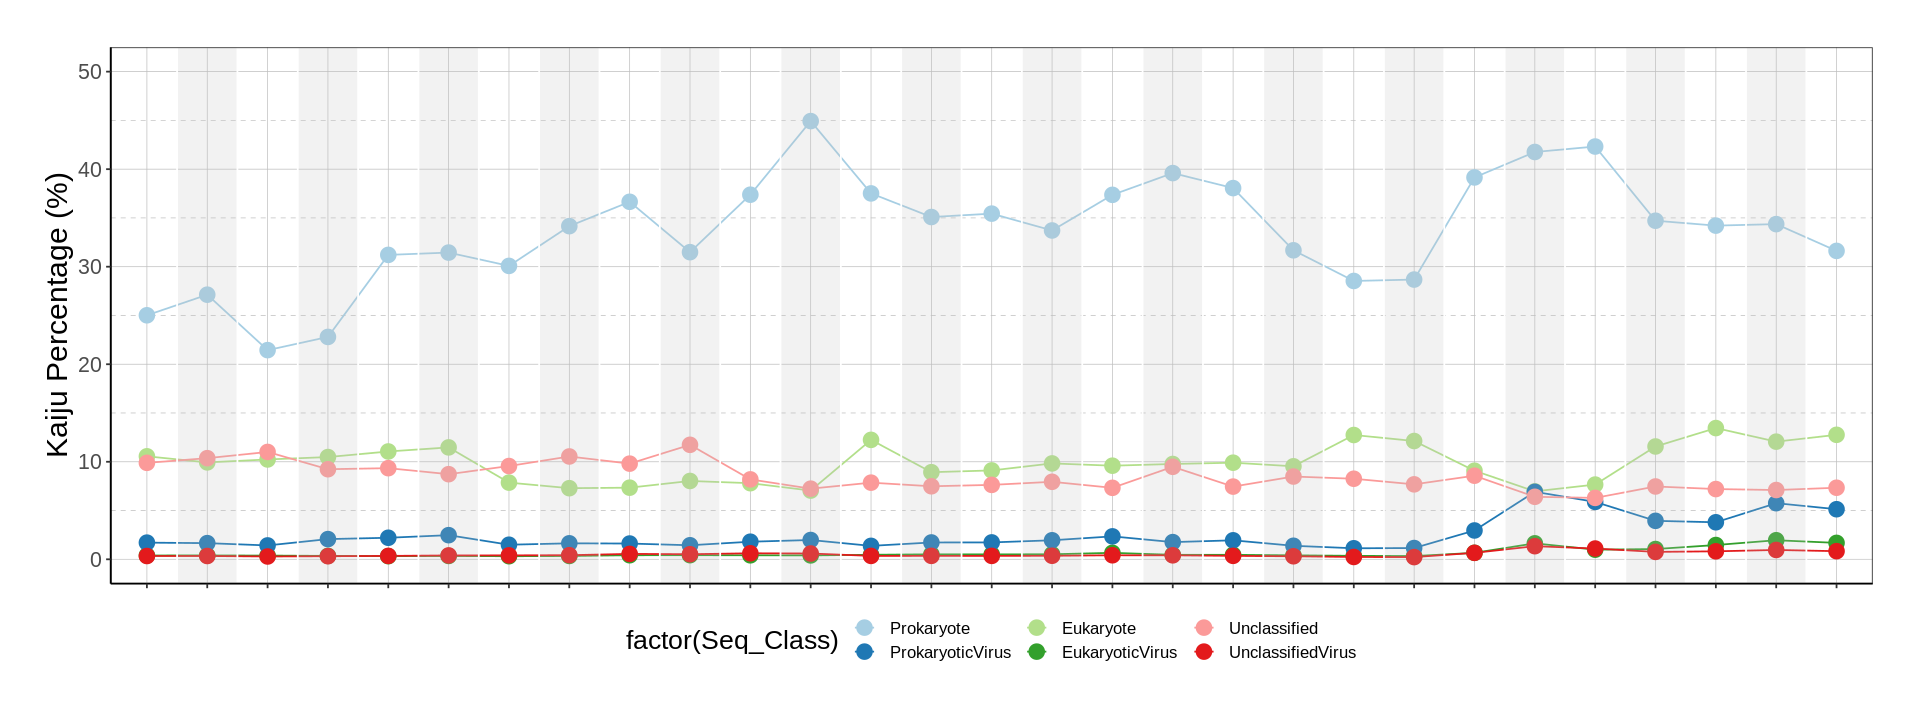

In [134]:
options(repr.plot.width=16, repr.plot.height=6)

# rects
rects <- data.frame(xmin = seq(1.5, 28.5, 2), 
                    xmax = seq(2.5, 29.5, 2))
head(rects, 2)

# plot with rects
p_kaiju_with_rects <- ggplot(data=kaiju_glbpct_meta_df.long, mapping=aes(x=Month_Day, y=Percentage, group=factor(Seq_Class), color=factor(Seq_Class))) + 
  geom_line(size=.5) + 
  geom_point(aes(fill=factor(Seq_Class)), size=4, shape=21) + 
  geom_rect(data=rects, mapping=aes(xmin=xmin, xmax=xmax, ymin = -Inf, ymax = Inf), fill="grey", color="white", alpha = 0.2, inherit.aes = FALSE) +
  scale_color_brewer(palette="Paired") + scale_fill_brewer(palette="Paired") + 
  scale_y_continuous(limits = c(0, 50), minor_breaks = seq(0, 50, 5), breaks = seq(0, 50, 10)) +
  my_theme1 + labs(y="Kaiju Percentage (%)") +
  theme(axis.text.x=element_blank(), axis.title.x=element_blank(), legend.position = "bottom")
  #theme(axis.text.x=element_text(angle=60,vjust=1), legend.position="bottom")
p_kaiju_with_rects

### - plot metaeuk SeqType percentages

In [135]:
metaeuk_glbpct_meta_df <- subset(metaeuk_relpct_df, select=-c(TotalCnt))
metaeuk_glbpct_meta_df <- metaeuk_glbpct_meta_df * metaeuk_relpct_df$TotalCnt / metadata_df$Total_Reads
metaeuk_glbpct_meta_df["Month_Day"] <- metadata_df[, c("Month_Day")]
head(metaeuk_glbpct_meta_df, 2)

,Eukaryote,EukaryoticVirus,Prokaryote,ProkaryoticVirus,Unclassified,UnclassifiedVirus,Month_Day
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ESPAEMG01_S37_L003,15.38599,0.1979279,25.94242,0.4660479,5.778818,0.1244797,Mar_18
ESPAEMG02_S38_L003,15.02124,0.1946049,28.10232,0.4783687,5.899707,0.1196192,Mar_19


In [136]:
metaeuk_glbpct_meta_df.long <- metaeuk_glbpct_meta_df %>% 
  mutate(Month_Day = factor(Month_Day, levels=Date_order)) %>% 
  select(Month_Day, Eukaryote, EukaryoticVirus, Prokaryote, ProkaryoticVirus, Unclassified, UnclassifiedVirus) %>% 
  gather(Eukaryote:UnclassifiedVirus, key="Seq_Class", value="Percentage") %>% 
  #mutate(Seq_Class = factor(Seq_Class, levels=c("Prokaryote", "ProkaryoteVirus", "Eukaryote", "EukaryoteVirus", "Plasmid"))) 
  mutate(Seq_Class = factor(Seq_Class, levels=c("Prokaryote", "ProkaryoticVirus", "Eukaryote", "EukaryoticVirus", "Unclassified", "UnclassifiedVirus"))) 

head(metaeuk_glbpct_meta_df.long, 2)

,Month_Day,Seq_Class,Percentage
,<fct>,<fct>,<dbl>
1,Mar_18,Eukaryote,15.38599
2,Mar_19,Eukaryote,15.02124


,xmin,xmax
,<dbl>,<dbl>
1,1.5,2.5
2,3.5,4.5


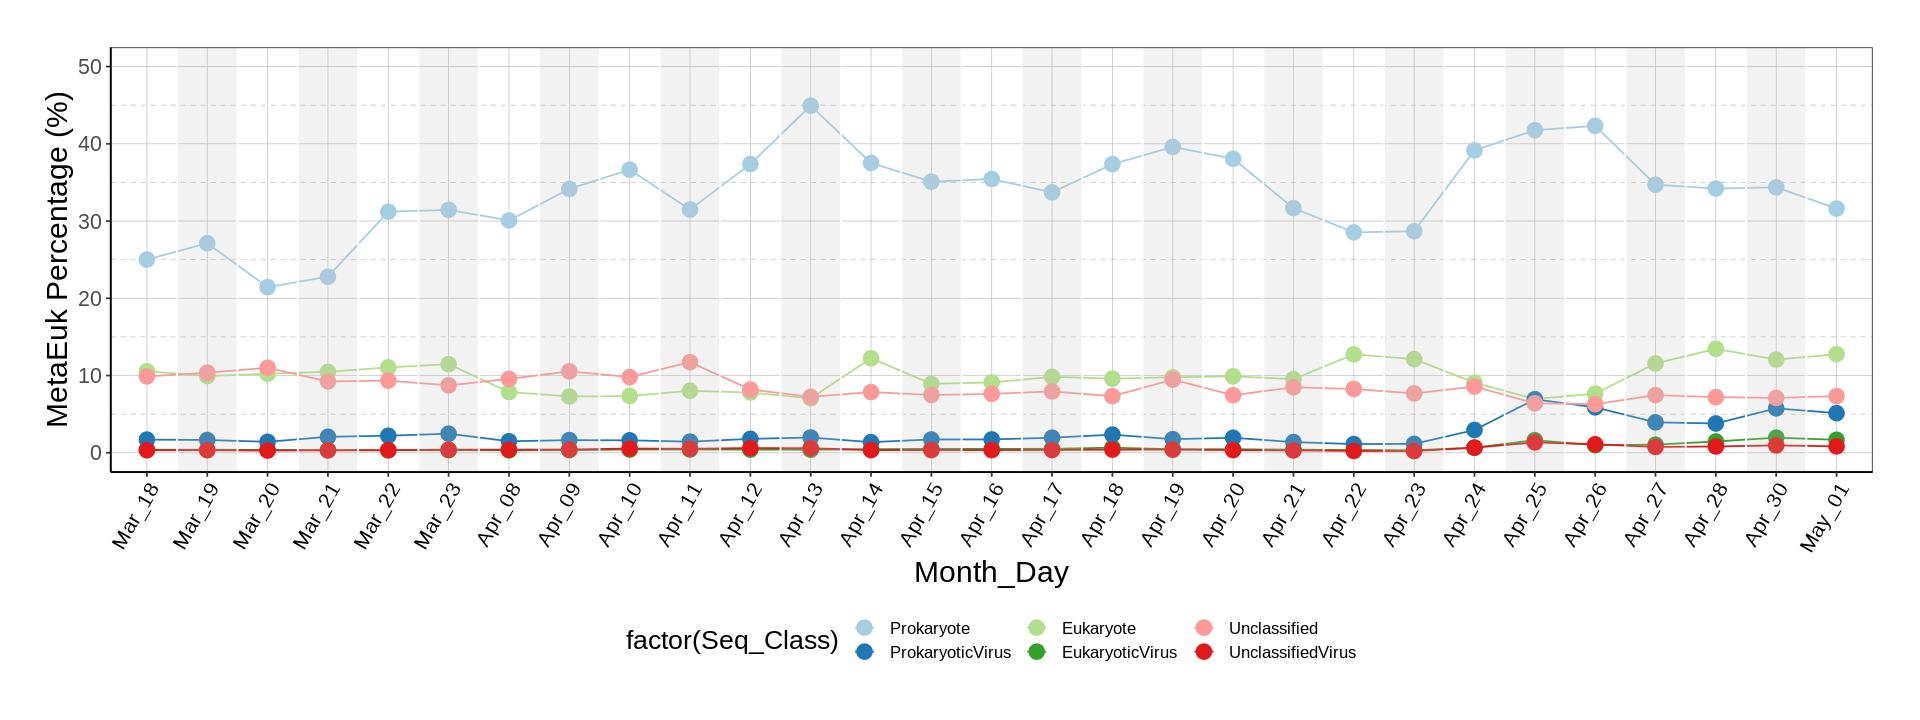

In [137]:
options(repr.plot.width=16, repr.plot.height=6)

# rects
rects <- data.frame(xmin = seq(1.5, 28.5, 2), 
                    xmax = seq(2.5, 29.5, 2))
head(rects, 2)

# plot with rects
p_metaeuk_with_rects <- ggplot(data=kaiju_glbpct_meta_df.long, mapping=aes(x=Month_Day, y=Percentage, group=factor(Seq_Class), color=factor(Seq_Class))) + 
  geom_line(size=.5) + 
  geom_point(aes(fill=factor(Seq_Class)), size=4, shape=21) + 
  geom_rect(data=rects, mapping=aes(xmin=xmin, xmax=xmax, ymin = -Inf, ymax = Inf), fill="grey", color="white", alpha = 0.2, inherit.aes = FALSE) +
  scale_color_brewer(palette="Paired") + scale_fill_brewer(palette="Paired") + 
  scale_y_continuous(limits = c(0, 50), minor_breaks = seq(0, 50, 5), breaks = seq(0, 50, 10)) +
  my_theme1 + labs(y="MetaEuk Percentage (%)") +  
  theme(axis.text.x=element_text(angle=60,vjust=1), legend.position="bottom")
p_metaeuk_with_rects

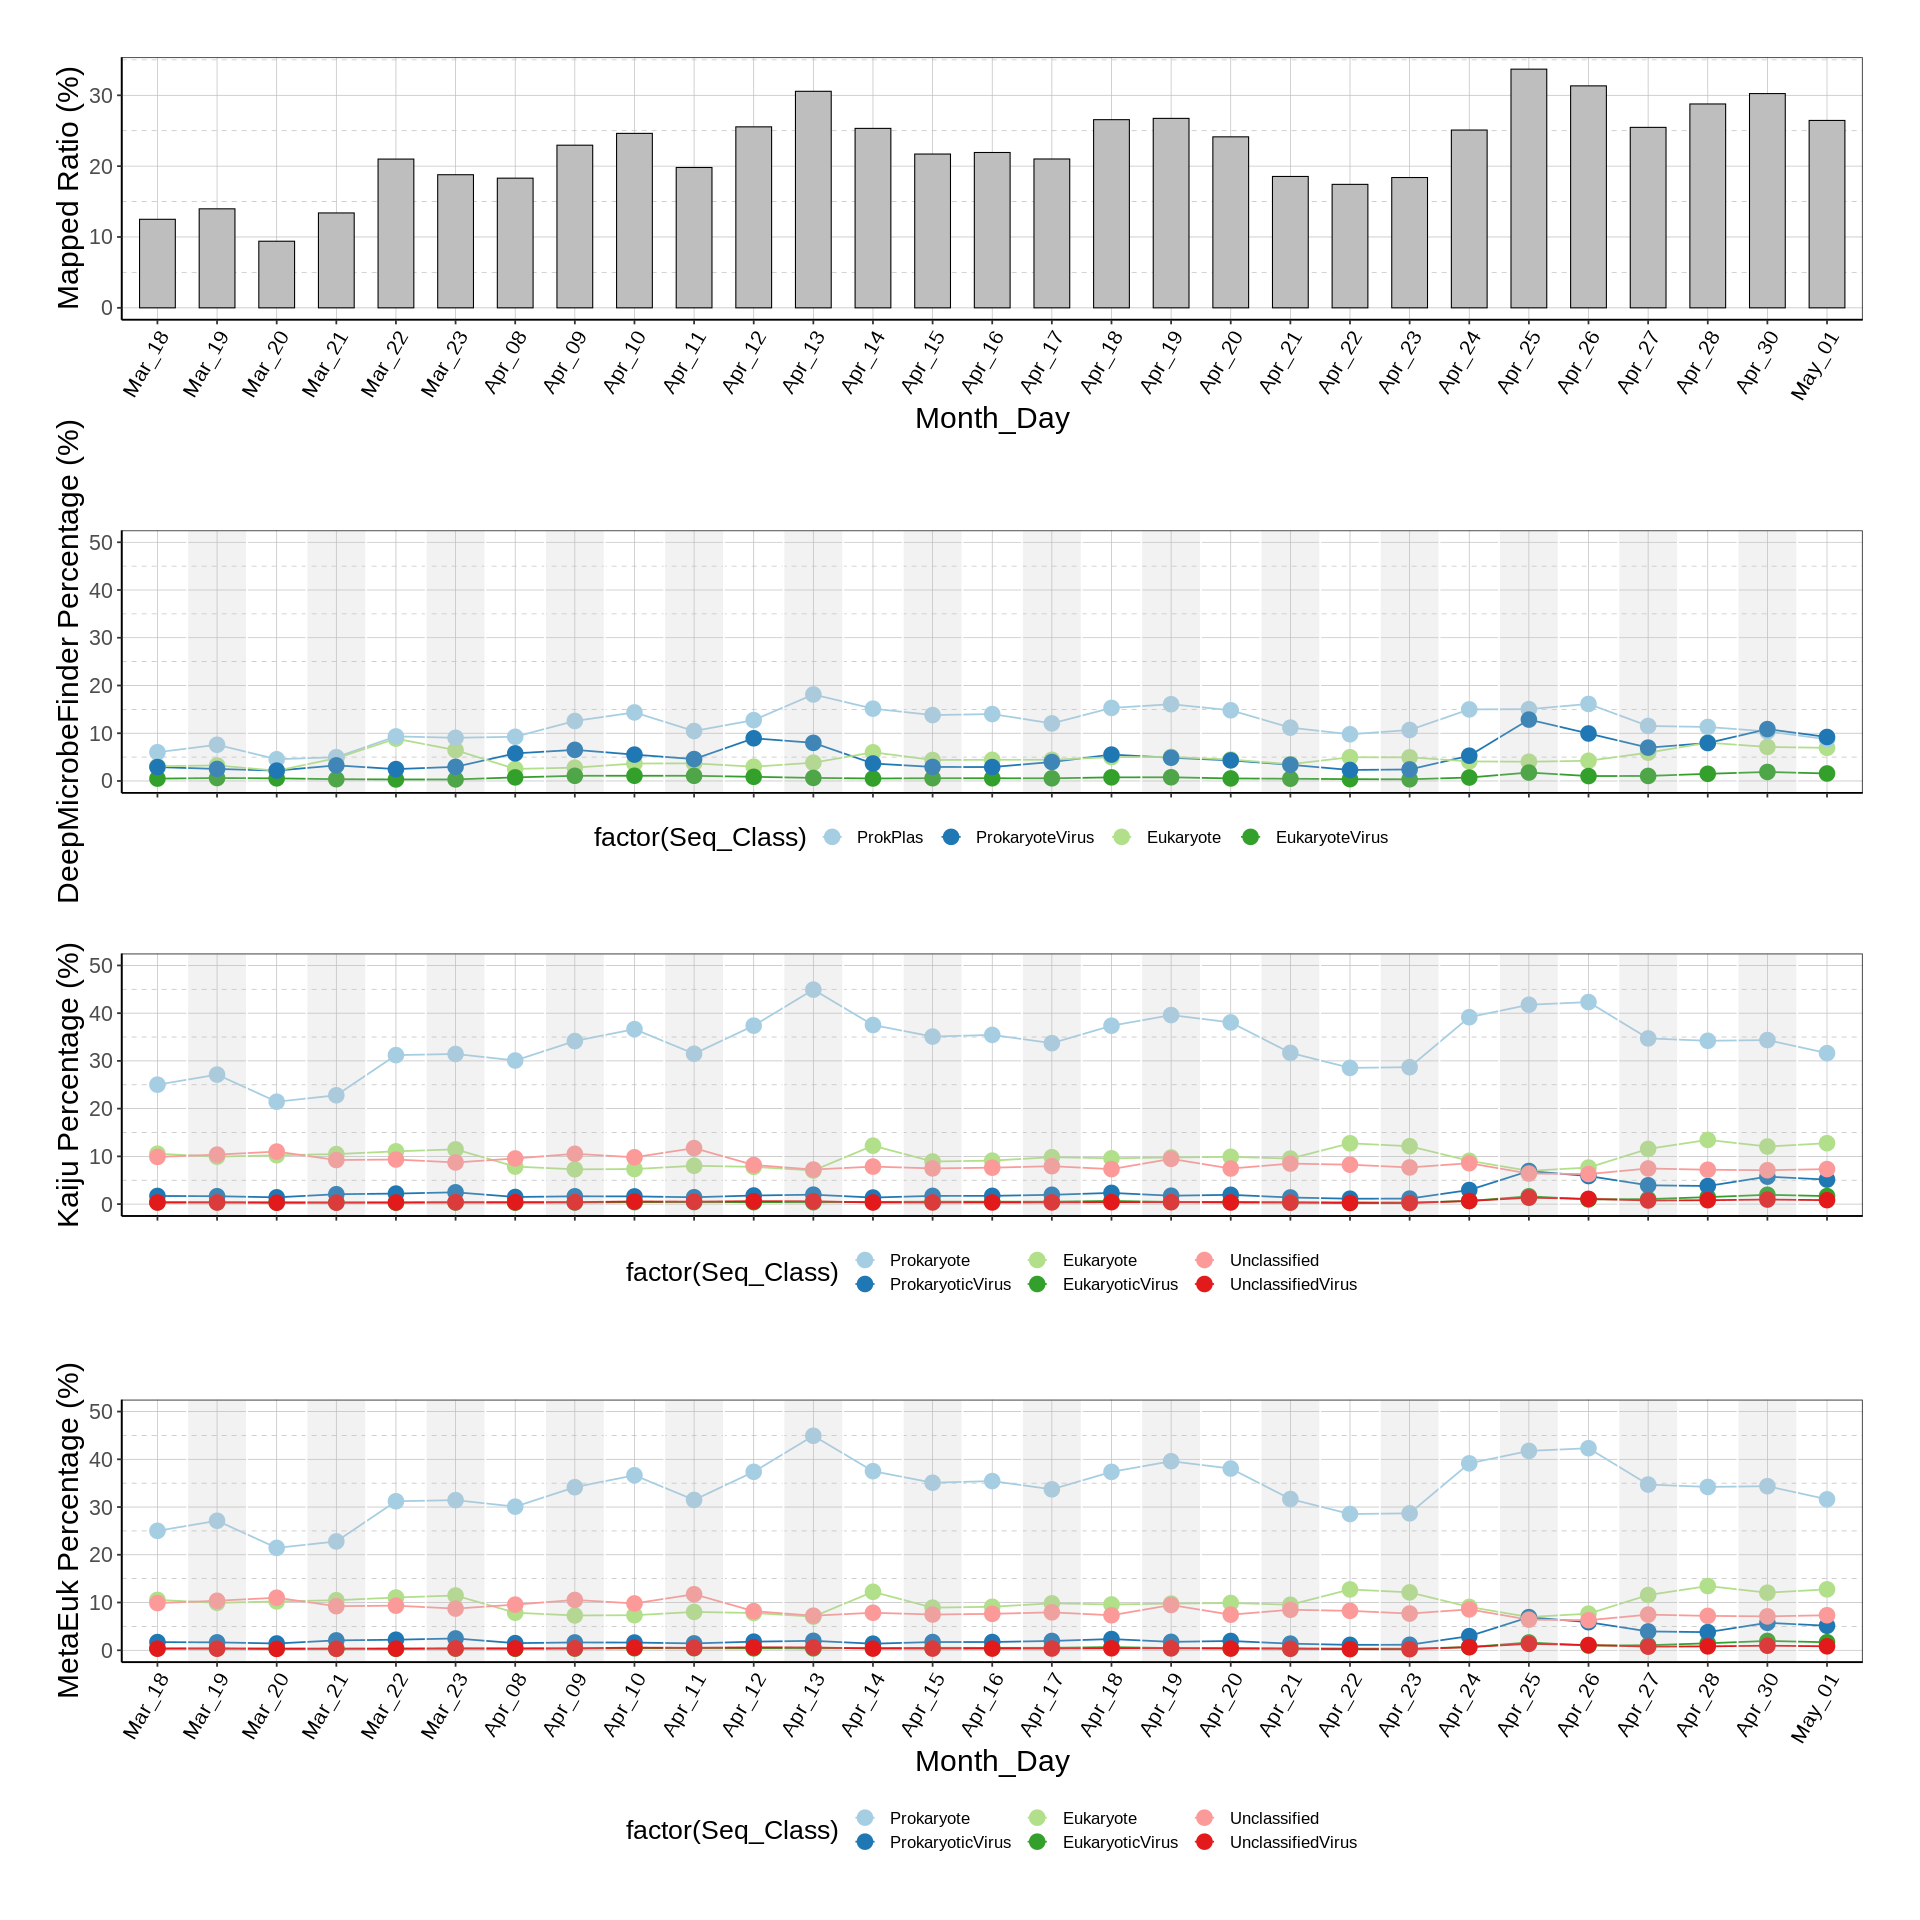

In [138]:
options(repr.plot.width=16, repr.plot.height=16)

library(patchwork)
p_map_ratio / p_def_with_rects / p_kaiju_with_rects / p_metaeuk_with_rects

ggsave(filename="ESPAE_kaiju_metaeuk_DEF_bwa_percentage_plot_2k_mapped.pdf", useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 400, height = 400, units = "mm",
       dpi = 300, limitsize = FALSE)

- correlations between eukaryotic percentages

metaeuk     kaiju       def 
13.738711  9.876705  4.675730

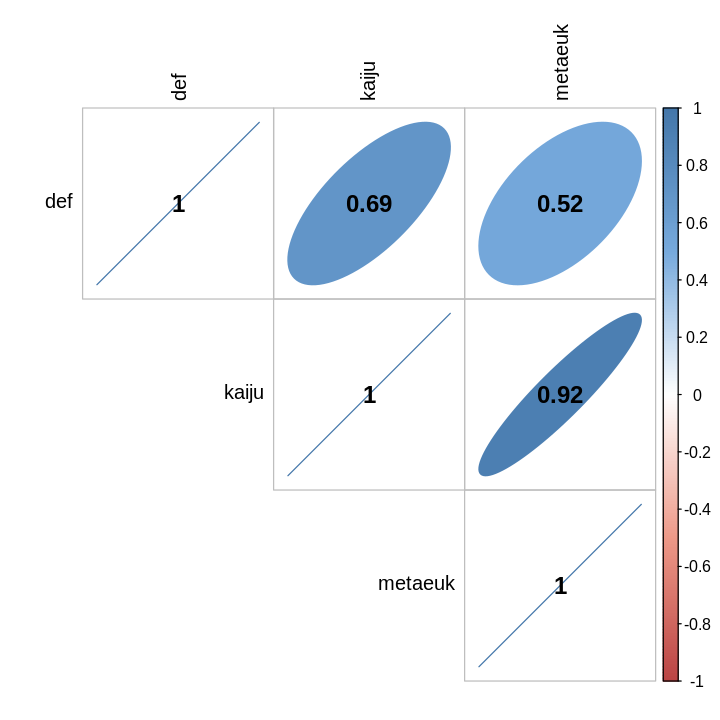

In [139]:
options(repr.plot.width=6, repr.plot.height=6)

euk_pct_df <- data.frame(metaeuk=metaeuk_glbpct_meta_df$Eukaryote, 
                         kaiju=kaiju_glbpct_meta_df$Eukaryote, 
                         def=def_glbpct_meta_df$Eukaryote)
#euk_pct_df.mclr <- mclr(euk_pct_df)

colMeans(euk_pct_df)

# `rcorr`
res2k <- rcorr(as.matrix(euk_pct_df))
res2k.r <- res2k$r
res2k.P <- res2k$P

col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))

#pdf(file = "ESPAE_kaiju_metaeuk_DEF_bwa_percentage_plot_2k_mapped_corrplot_euk.pdf")
corrplot(res2k.r, method = "ellipse", col = col(200), #method = "color",
         type = "upper", order = "alphabet", number.cex = 1.2,
         addCoef.col = "black", # Add coefficient of correlation
         tl.col = "black", tl.srt = 90, # Text label color and rotation
         # Combine with significance
         p.mat = res2k.P, sig.level = 0.01, insig = "blank", 
         # show correlation coefficient on the principal diagonal
         diag = TRUE)
#dev.off()

In [140]:
cor_fun <- function(x, y, method){
  tmp <- cor.test(x, y, method= method)
  cbind(r=tmp$estimate, p=tmp$p.value)
}

cor_results <- apply(X=euk_pct_df, MARGIN=2, FUN=cor_fun, x=euk_pct_df[, 3], method="spearman")
rownames(cor_results) <- c("cor", "p.value")
cor_results

,metaeuk,kaiju,def
cor,0.579802956,6.832512e-01,1
p.value,0.001200092,6.783525e-05,0


metaeuk    kaiju      def 
34.36465 33.70863  9.71265

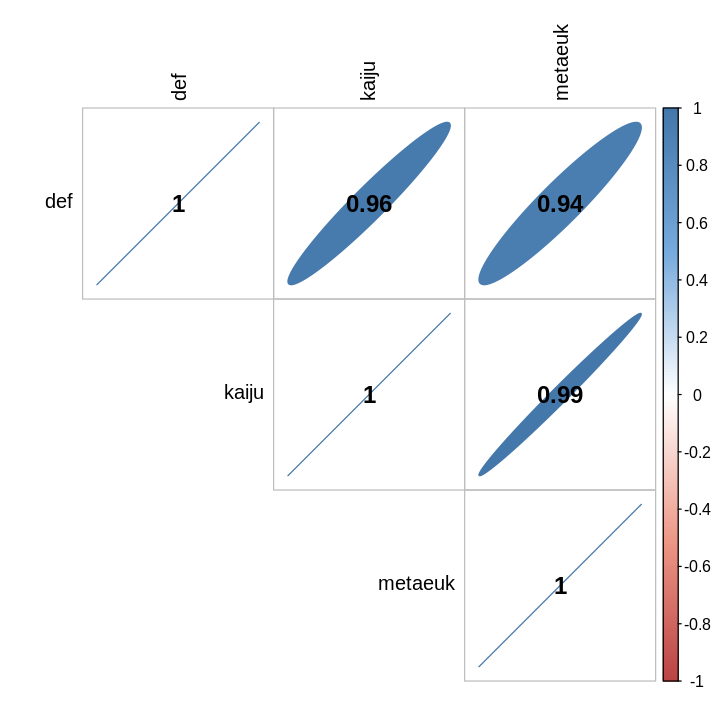

In [141]:
options(repr.plot.width=6, repr.plot.height=6)

prok_pct_df <- data.frame(metaeuk=metaeuk_glbpct_meta_df$Prokaryote, 
                         kaiju=kaiju_glbpct_meta_df$Prokaryote, 
                         def=def_glbpct_meta_df$Prokaryote)
colMeans(prok_pct_df)

# `rcorr`
res2k <- rcorr(as.matrix(prok_pct_df))
res2k.r <- res2k$r
res2k.P <- res2k$P

col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))

#pdf(file = "ESPAE_kaiju_metaeuk_DEF_bwa_percentage_plot_2k_mapped_corrplot_prok.pdf")
corrplot(res2k.r, method = "ellipse", col = col(200), #method = "color",
         type = "upper", order = "alphabet", number.cex = 1.2,
         addCoef.col = "black", # Add coefficient of correlation
         tl.col = "black", tl.srt = 90, # Text label color and rotation
         # Combine with significance
         p.mat = res2k.P, sig.level = 0.01, insig = "blank", 
         # show correlation coefficient on the principal diagonal
         diag = TRUE)
#dev.off()

metaeuk     kaiju       def 
0.7509478 2.4947145 5.3439252

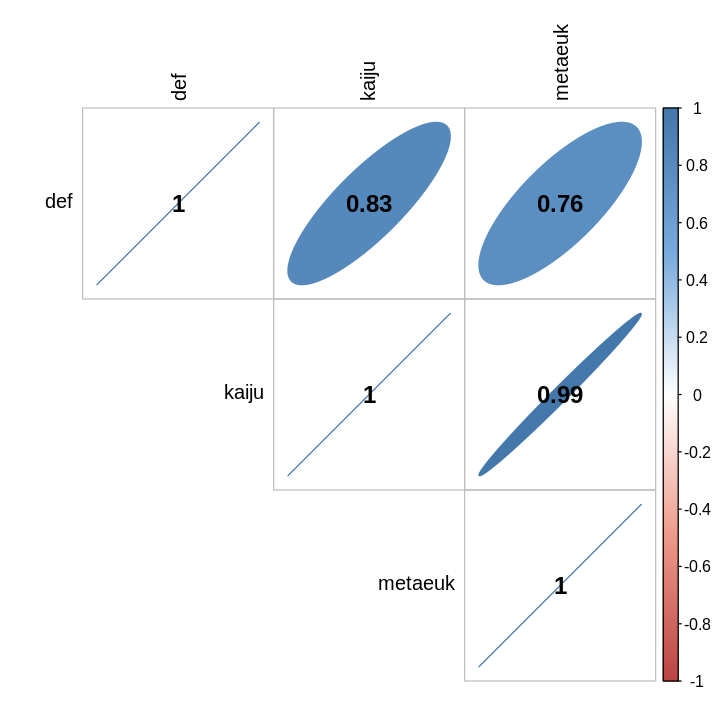

In [142]:
options(repr.plot.width=6, repr.plot.height=6)

library("Hmisc")
library("corrplot")

prokvir_pct_df <- data.frame(metaeuk=metaeuk_glbpct_meta_df$ProkaryoticVirus, 
                         kaiju=kaiju_glbpct_meta_df$ProkaryoticVirus, 
                         def=def_glbpct_meta_df$ProkaryoteVirus)
colMeans(prokvir_pct_df)

# `rcorr`
res2k <- rcorr(as.matrix(prokvir_pct_df))
res2k.r <- res2k$r
res2k.P <- res2k$P

col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))

#pdf(file = "ESPAE_kaiju_metaeuk_DEF_bwa_percentage_plot_2k_mapped_corrplot_prokvir.pdf")
corrplot(res2k.r, method = "ellipse", col = col(200), #method = "color",
         type = "upper", order = "alphabet", number.cex = 1.2,
         addCoef.col = "black", # Add coefficient of correlation
         tl.col = "black", tl.srt = 90, # Text label color and rotation
         # Combine with significance
         p.mat = res2k.P, sig.level = 0.01, insig = "blank", 
         # show correlation coefficient on the principal diagonal
         diag = TRUE)

#dev.off()

metaeuk     kaiju       def 
0.3139529 0.6396204 0.7987033

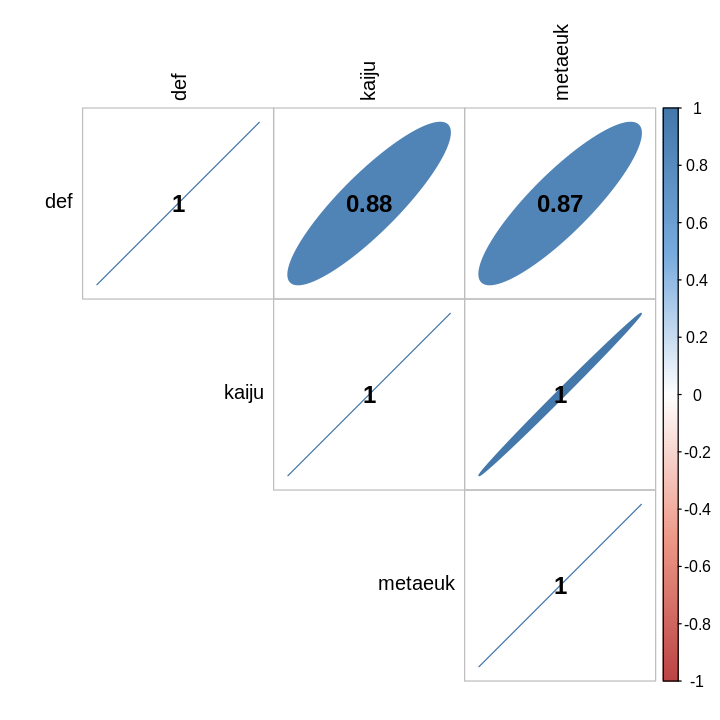

In [143]:
options(repr.plot.width=6, repr.plot.height=6)

library("Hmisc")
library("corrplot")

eukvir_pct_df <- data.frame(metaeuk=metaeuk_glbpct_meta_df$EukaryoticVirus, 
                         kaiju=kaiju_glbpct_meta_df$EukaryoticVirus, 
                         def=def_glbpct_meta_df$EukaryoteVirus)
colMeans(eukvir_pct_df)

# `rcorr`
res2k <- rcorr(as.matrix(eukvir_pct_df))
res2k.r <- res2k$r
res2k.P <- res2k$P

col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))

#pdf(file = "ESPAE_kaiju_metaeuk_DEF_bwa_percentage_plot_2k_mapped_corrplot_eukvir.pdf")
corrplot(res2k.r, method = "ellipse", col = col(200), #method = "color",
         type = "upper", order = "alphabet", number.cex = 1.2,
         addCoef.col = "black", # Add coefficient of correlation
         tl.col = "black", tl.srt = 90, # Text label color and rotation
         # Combine with significance
         p.mat = res2k.P, sig.level = 0.01, insig = "blank", 
         # show correlation coefficient on the principal diagonal
         diag = TRUE)
#dev.off()

### read in gRodon

In [144]:
gRodon_results_All <- "ESPAEMG_gRodon_OGT.tsv"
gRodon_results_ProkPlas <- "ESPAEMG_gRodon_OGT_ProkPlas.tsv"
gRodon_df_All <- read.table(gRodon_results_All, header = T, sep = "\t", as.is = T, stringsAsFactors = F)
gRodon_df <- read.table(gRodon_results_ProkPlas, header = T, sep = "\t", as.is = T, stringsAsFactors = F)

head(gRodon_df, 2)

,Sample_Name,Month_Day,Month,Day,CUBHE,ConsistencyHE,CPB,FilteredSequences,OGT,d,LowerCI,UpperCI
,<chr>,<chr>,<int>,<int>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,ESPAEMG01_S37_L003,Mar_18,3,18,0.9016142,NA,NA,20975,16.14,0.8036018,0.6089447,1.072563
2,ESPAEMG02_S38_L003,Mar_19,3,19,0.8339356,NA,NA,23636,16.25,1.2583083,0.9799005,1.630700


In [145]:
### global percentages
head(def_glbpct_meta_df, 2)
### relative percentages 
def_relpct_meta_df <- subset(def_relpct_df, select=-c(TotalCnt))
def_relpct_meta_df["Month_Day"] <- metadata_df[, c("Month_Day")]
head(def_relpct_meta_df, 2)

### use global
read_pct_meta_df <- def_glbpct_meta_df
read_pct_meta_df["ProkPlas"] <- read_pct_meta_df["Prokaryote"] + read_pct_meta_df["Plasmid"]
read_pct_meta_df <- read_pct_meta_df[, -which(colnames(read_pct_meta_df) %in% c("Prokaryote", "Plasmid"))]
head(read_pct_meta_df, 2)

,Eukaryote,EukaryoteVirus,Plasmid,Prokaryote,ProkaryoteVirus,Month_Day
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ESPAEMG01_S37_L003,3.080484,0.4906688,1.112950,4.904290,2.909895,Mar_18
ESPAEMG02_S38_L003,3.257445,0.6160352,1.287551,6.294577,2.519630,Mar_19


,Eukaryote,EukaryoteVirus,Plasmid,Prokaryote,ProkaryoteVirus,Month_Day
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ESPAEMG01_S37_L003,24.64725,3.925888,8.904819,39.23969,23.28235,Mar_18
ESPAEMG02_S38_L003,23.30869,4.408048,9.213087,45.04093,18.02924,Mar_19


,Eukaryote,EukaryoteVirus,ProkaryoteVirus,Month_Day,ProkPlas
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
ESPAEMG01_S37_L003,3.080484,0.4906688,2.909895,Mar_18,6.017240
ESPAEMG02_S38_L003,3.257445,0.6160352,2.519630,Mar_19,7.582128


In [146]:
# add DoublingTime
read_pct_meta_df["DoublingTime"] <- gRodon_df[, "d"]
# d = ln(2)/u  ==> u = ln(2)/d ==> u = 24*ln(2)/d
read_pct_meta_df["GrowthRate"] <- 24*log(2)/(read_pct_meta_df["DoublingTime"])
head(read_pct_meta_df, 2)

,Eukaryote,EukaryoteVirus,ProkaryoteVirus,Month_Day,ProkPlas,DoublingTime,GrowthRate
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
ESPAEMG01_S37_L003,3.080484,0.4906688,2.909895,Mar_18,6.017240,0.8036018,20.70121
ESPAEMG02_S38_L003,3.257445,0.6160352,2.519630,Mar_19,7.582128,1.2583083,13.22055


In [147]:
# use modified central log ratio (mclr) transformation from the SPRING package
read_pct_meta_df.mclr <- mclr(read_pct_meta_df[, -which(colnames(read_pct_meta_df) %in% c("Month_Day", "DoublingTime", "GrowthRate"))])
read_pct_meta_df.mclr <- cbind(read_pct_meta_df.mclr, read_pct_meta_df[, c("GrowthRate", "DoublingTime")])
head(read_pct_meta_df.mclr, 2)

,Eukaryote,EukaryoteVirus,ProkaryoteVirus,ProkPlas,GrowthRate,DoublingTime
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ESPAEMG01_S37_L003,3.498491,1.661419,3.441521,4.168033,20.70121,0.8036018
ESPAEMG02_S38_L003,3.461710,1.796315,3.204879,4.306560,13.22055,1.2583083


In [148]:
library("Hmisc")

# `rcorr`
res2k <- rcorr(as.matrix(read_pct_meta_df.mclr))
res2k.r <- res2k$r
res2k.P <- res2k$P

In [149]:
?rcorr

rcorr                  package:Hmisc                   R Documentation

_M_a_t_r_i_x _o_f _C_o_r_r_e_l_a_t_i_o_n_s _a_n_d _P-_v_a_l_u_e_s

_D_e_s_c_r_i_p_t_i_o_n:

     ‘rcorr’ Computes a matrix of Pearson's ‘r’ or Spearman's ‘rho’
     rank correlation coefficients for all possible pairs of columns of
     a matrix.  Missing values are deleted in pairs rather than
     deleting all rows of ‘x’ having any missing variables.  Ranks are
     computed using efficient algorithms (see reference 2), using
     midranks for ties.

_U_s_a_g_e:

     rcorr(x, y, type=c("pearson","spearman"))
     
     ## S3 method for class 'rcorr'
     print(x, ...)
     
_A_r_g_u_m_e_n_t_s:

       x: a numeric matrix with at least 5 rows and at least 2 columns
          (if ‘y’ is absent).  For ‘print’, ‘x’ is an object produced
          by ‘rcorr’.

       y: a numeric vector or matrix which will be concatenated to ‘x’.
          If ‘y’ is omitted for

In [150]:
options(repr.plot.width=10, repr.plot.height=10)

library("corrplot")
col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))

pdf(file = "ESPAE_2k_percentage_corrplot_onlyGrowthRate.pdf")
corrplot(res2k.r, method = "ellipse", col = col(200), #method = "color",
         type = "upper", order = "hclust", number.cex = 1.2,
         addCoef.col = "black", # Add coefficient of correlation
         tl.col = "black", tl.srt = 90, # Text label color and rotation
         # Combine with significance
         p.mat = res2k.P, sig.level = 0.01, insig = "blank", 
         # show correlation coefficient on the principal diagonal
         diag = FALSE)
dev.off()

png 
  2

**- plot doublingtime with clr transformation**

,DoublingTime,Dataset,Percentage
,<dbl>,<fct>,<dbl>
1,0.8036018,ProkPlas,4.168033
2,1.2583083,ProkPlas,4.306560


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



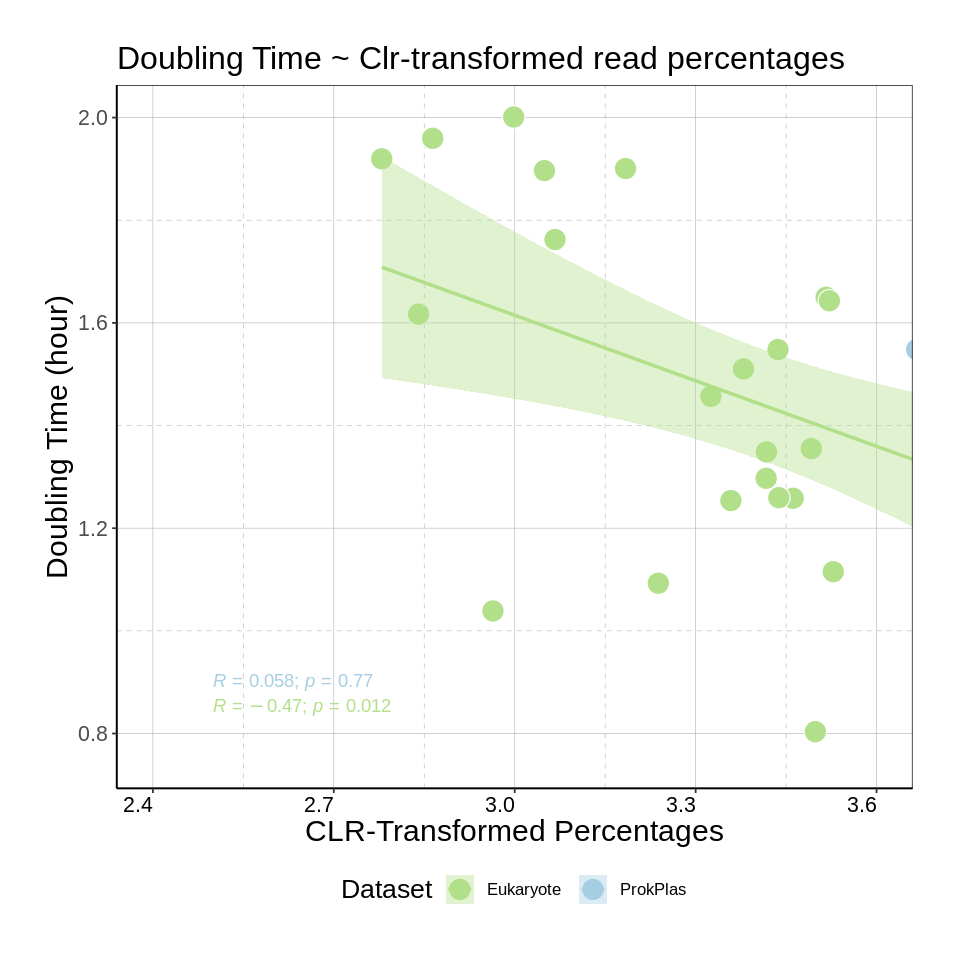

In [151]:
options(repr.plot.width=8, repr.plot.height=8)


read_pct_meta_df.mclr.growth <- data.frame(read_pct_meta_df.mclr) %>% 
    select(DoublingTime, ProkPlas, Eukaryote) %>% 
    #select(DoublingTime, Prokaryote, ProkaryoteVirus, Eukaryote, EukaryoteVirus, Plasmid) %>% 
    gather(ProkPlas:Eukaryote, key="Dataset", value="Percentage") %>%
    mutate(Dataset = factor(Dataset)) %>% 
    filter(DoublingTime >= 0.5)

head(read_pct_meta_df.mclr.growth, 2)

library(tidyverse)
library(ggpubr)
theme_set(theme_pubr())

ggscatter(read_pct_meta_df.mclr.growth, x = "Percentage", y = "DoublingTime", 
          xlab = "CLR-Transformed Percentages", ylab = "Doubling Time (hour)", 
          size = 6, shape = 21, color = "white", fill="Dataset",
          title = "Doubling Time ~ Clr-transformed read percentages",
          #palette = "jco",
          #palette = c('#B2DF8A', '#FB9A99', '#A6CEE3'), 
          palette = c('#B2DF8A', '#A6CEE3'), 
          #facet.by = "Dataset", 
          scales = "free_y",
          xlim = c(2.4, 3.6),
          add = "reg.line", 
          add.params = list(color = "Dataset", fill = "Dataset"), # Customize reg. line
          conf.int = TRUE # Add confidence interval
         ) +
  stat_cor(aes(color = Dataset), method = "spearman", label.x = 2.5, label.y = c(0.85, 0.9), label.sep = "; ") + my_theme1

ggsave(filename="ESPAE_kaiju_metaeuk_DEF_bwa_percentage_plot_2k_DoublingTime_clr.pdf", useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 200, height = 200, units = "mm",
       dpi = 300, limitsize = FALSE)

**- plot doublingtime without clr transformation**

,DoublingTime,Dataset,Percentage
,<dbl>,<fct>,<dbl>
1,0.8036018,ProkPlas,6.017240
2,1.2583083,ProkPlas,7.582128


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



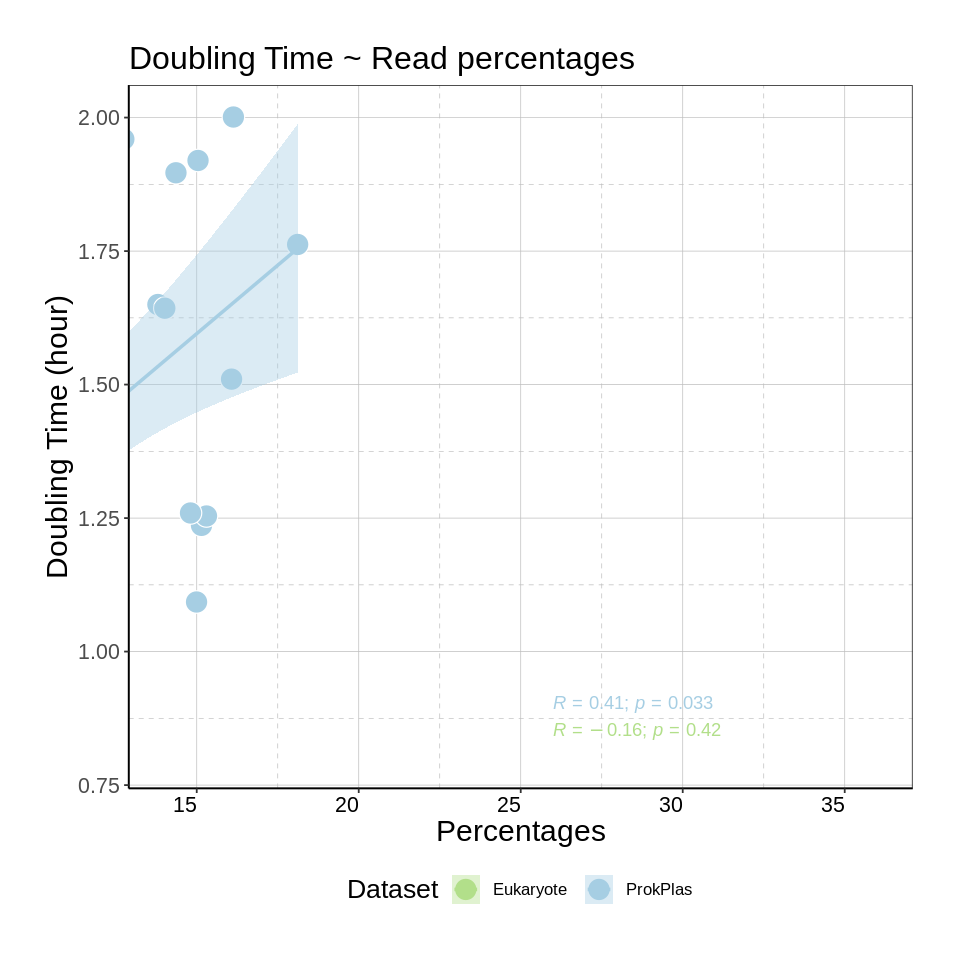

In [152]:
options(repr.plot.width=8, repr.plot.height=8)


read_pct_meta_df.growth <- data.frame(read_pct_meta_df) %>% 
    select(DoublingTime, ProkPlas, Eukaryote) %>% 
    #select(DoublingTime, Prokaryote, ProkaryoteVirus, Eukaryote, EukaryoteVirus, Plasmid) %>% 
    gather(ProkPlas:Eukaryote, key="Dataset", value="Percentage") %>%
    mutate(Dataset = factor(Dataset)) %>% 
    filter(DoublingTime >= 0.5)

head(read_pct_meta_df.growth, 2)

library(tidyverse)
library(ggpubr)
theme_set(theme_pubr())

ggscatter(read_pct_meta_df.growth, x = "Percentage", y = "DoublingTime",  
          xlab = "Percentages", ylab = "Doubling Time (hour)", 
          size = 6, shape = 21, color = "white", fill="Dataset",
          title = "Doubling Time ~ Read percentages",
          #palette = "jco",
          #palette = c('#B2DF8A', '#FB9A99', '#A6CEE3'), 
          palette = c('#B2DF8A', '#A6CEE3'), 
          #facet.by = "Dataset", 
          scales = "free_y",
          xlim = c(14, 36),
          add = "reg.line", 
          add.params = list(color = "Dataset", fill = "Dataset"), # Customize reg. line
          conf.int = TRUE # Add confidence interval
         ) +
  stat_cor(aes(color = Dataset), method = "spearman", label.x = 26, label.y = c(0.85, 0.9), label.sep = "; ") + my_theme1

ggsave(filename="ESPAE_kaiju_metaeuk_DEF_bwa_percentage_plot_2k_DoublingTime.pdf", useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 200, height = 200, units = "mm",
       dpi = 300, limitsize = FALSE)

**- plot growthrate with clr transformation**

,GrowthRate,Dataset,Percentage
,<dbl>,<fct>,<dbl>
1,20.70121,ProkPlas,4.168033
2,13.22055,ProkPlas,4.306560


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



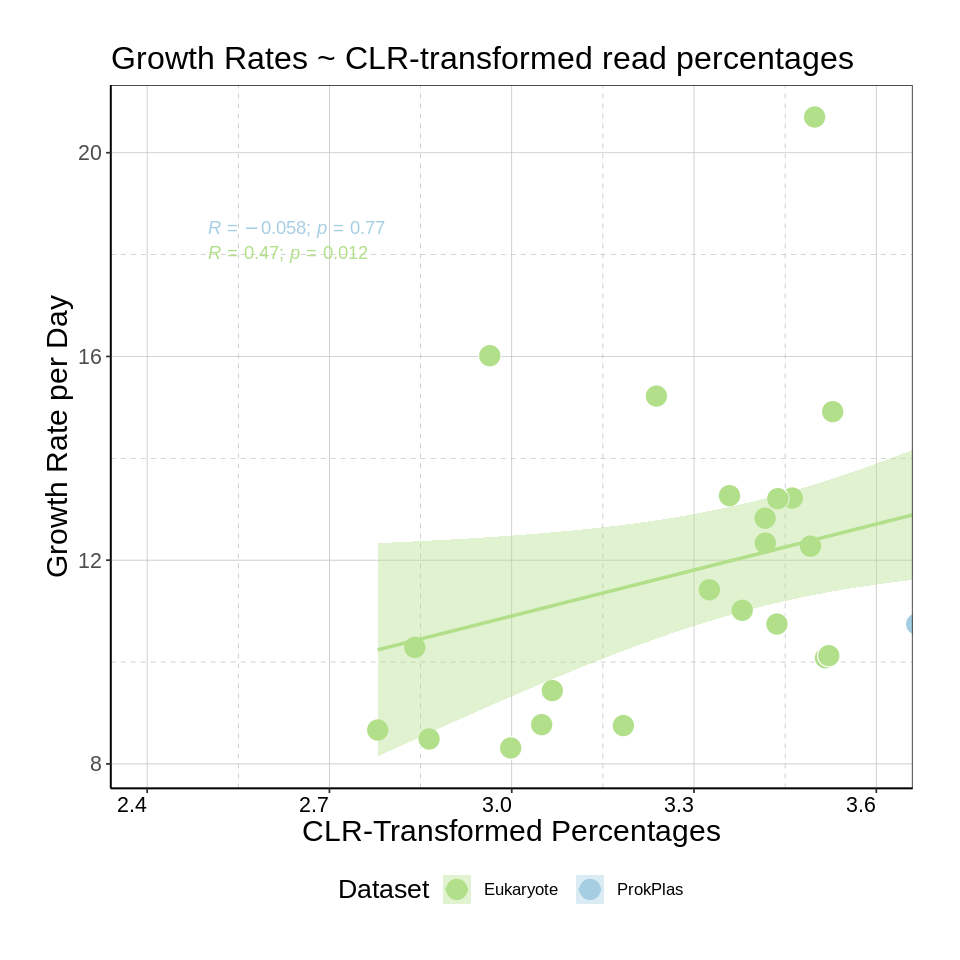

In [153]:
options(repr.plot.width=8, repr.plot.height=8)


read_pct_meta_df.mclr.growth <- data.frame(read_pct_meta_df.mclr) %>% 
    select(GrowthRate, ProkPlas, Eukaryote) %>% 
    #select(DoublingTime, Prokaryote, ProkaryoteVirus, Eukaryote, EukaryoteVirus, Plasmid) %>% 
    gather(ProkPlas:Eukaryote, key="Dataset", value="Percentage") %>%
    mutate(Dataset = factor(Dataset)) %>% 
    filter(GrowthRate <= 25) 

head(read_pct_meta_df.mclr.growth, 2)

library(tidyverse)
library(ggpubr)
theme_set(theme_pubr())

ggscatter(read_pct_meta_df.mclr.growth, x = "Percentage", y = "GrowthRate",  
          xlab = "CLR-Transformed Percentages", ylab = "Growth Rate per Day", 
          size = 6, shape = 21, color = "white", fill="Dataset",
          title = "Growth Rates ~ CLR-transformed read percentages",
          #palette = "jco",
          #palette = c('#B2DF8A', '#FB9A99', '#A6CEE3'), 
          palette = c('#B2DF8A', '#A6CEE3'), 
          #facet.by = "Dataset", 
          scales = "free_y",
          xlim = c(2.4, 3.6),
          add = "reg.line", 
          add.params = list(color = "Dataset", fill = "Dataset"), # Customize reg. line
          conf.int = TRUE # Add confidence interval
         ) +
  stat_cor(aes(color = Dataset), method = "spearman", label.x = 2.5, label.y = c(18, 18.5), label.sep = "; ") + my_theme1

ggsave(filename="ESPAE_kaiju_metaeuk_DEF_bwa_percentage_plot_2k_GrowthRate_clr.pdf", useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 200, height = 200, units = "mm",
       dpi = 300, limitsize = FALSE)

**- plot growthrate without clr transformation**

,GrowthRate,Dataset,Percentage
,<dbl>,<fct>,<dbl>
1,20.70121,ProkPlas,6.017240
2,13.22055,ProkPlas,7.582128


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



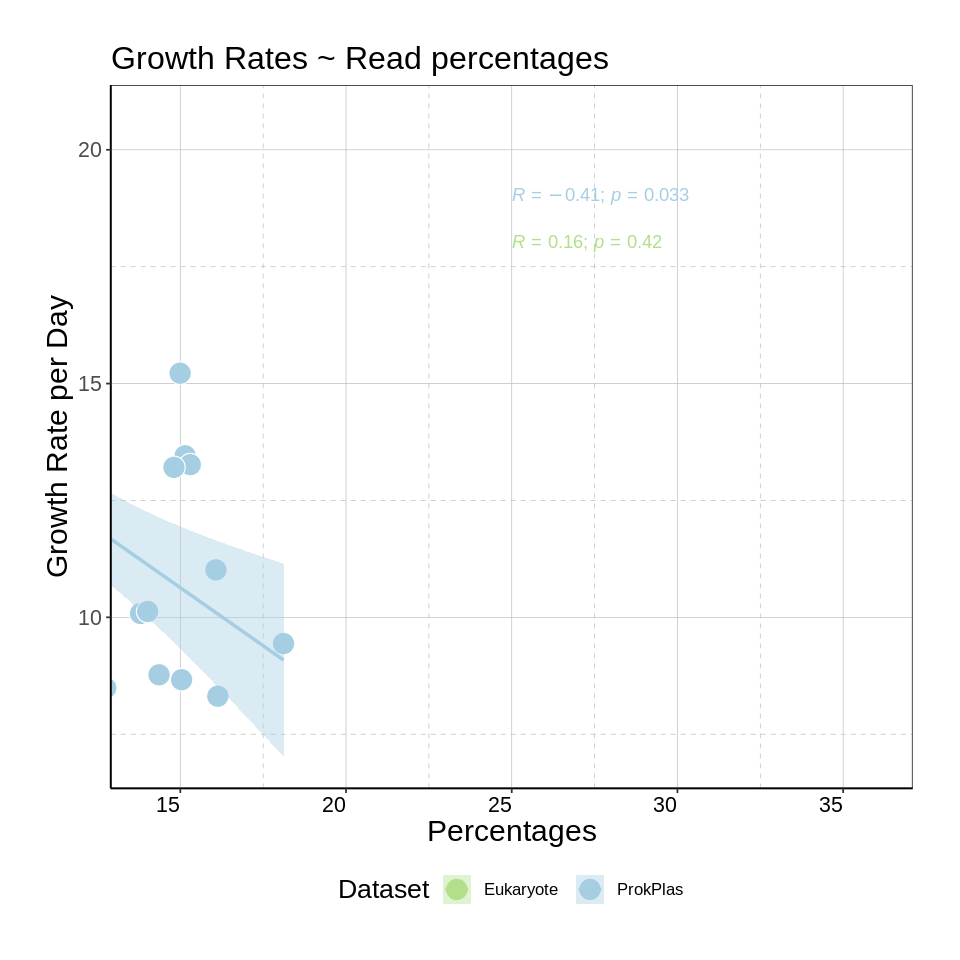

In [154]:
options(repr.plot.width=8, repr.plot.height=8)


read_pct_meta_df.growth <- data.frame(read_pct_meta_df) %>% 
    select(GrowthRate, ProkPlas, Eukaryote) %>% 
    #select(DoublingTime, Prokaryote, ProkaryoteVirus, Eukaryote, EukaryoteVirus, Plasmid) %>% 
    gather(ProkPlas:Eukaryote, key="Dataset", value="Percentage") %>%
    mutate(Dataset = factor(Dataset)) %>%
    filter(GrowthRate <= 25) 

head(read_pct_meta_df.growth, 2)

library(tidyverse)
library(ggpubr)
theme_set(theme_pubr())

ggscatter(read_pct_meta_df.growth, x = "Percentage", y = "GrowthRate",  
          xlab = "Percentages", ylab = "Growth Rate per Day", 
          size = 6, shape = 21, color = "white", fill="Dataset",
          title = "Growth Rates ~ Read percentages",
          #palette = "jco",
          #palette = c('#B2DF8A', '#FB9A99', '#A6CEE3'), 
          palette = c('#B2DF8A', '#A6CEE3'), 
          #facet.by = "Dataset", 
          scales = "free_y",
          xlim = c(14, 36),
          add = "reg.line", 
          add.params = list(color = "Dataset", fill = "Dataset"), # Customize reg. line
          conf.int = TRUE # Add confidence interval
         ) +
  stat_cor(aes(color = Dataset), method = "spearman", label.x = 25, label.y = c(18, 19), label.sep = "; ") + my_theme1

ggsave(filename="ESPAE_kaiju_metaeuk_DEF_bwa_percentage_plot_2k_GrowthRate.pdf", useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 200, height = 200, units = "mm",
       dpi = 300, limitsize = FALSE)

* Is the growth rate of sample Mar_20 an outlier? Let's test it using Grubbs test from the `outliers` package

In [155]:
# one growth rate observation is 37.25 
read_pct_meta_df[read_pct_meta_df$GrowthRate >=25, ]
metadata_df["ESPAEMG03_S39_L003", ]

,Eukaryote,EukaryoteVirus,ProkaryoteVirus,Month_Day,ProkPlas,DoublingTime,GrowthRate
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
ESPAEMG03_S39_L003,2.135575,0.5472382,2.171564,Mar_20,4.548521,0.4465829,37.25072


,Library_Type,Filter_Fraction,Month_Day,Month,Day,Time,Temperature,Depth,Salinity,Chlorophyll,Transmission,Total_Reads
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
ESPAEMG03_S39_L003,MG,AE,Mar_20,3,20,AM,16.283,4.689,33.448,0.54,94.6,94646542


In [156]:
ol.test <- grubbs.test(read_pct_meta_df$GrowthRate)
ol.test


	Grubbs test for one outlier

data:  read_pct_meta_df$GrowthRate
G = 4.44251, U = 0.26997, p-value = 5.362e-08
alternative hypothesis: highest value 37.2507181955821 is an outlier


In [157]:
library(lme4)
growth.lm <- lm(data=read_pct_meta_df.mclr, GrowthRate ~ ProkPlas + ProkaryoteVirus + Eukaryote + EukaryoteVirus)
summary(growth.lm)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack





Call:
lm(formula = GrowthRate ~ ProkPlas + ProkaryoteVirus + Eukaryote + 
    EukaryoteVirus, data = read_pct_meta_df.mclr)

Residuals:
   Min     1Q Median     3Q    Max 
-6.497 -2.707 -1.165  1.410 20.796 

Coefficients: (1 not defined because of singularities)
                Estimate Std. Error t value Pr(>|t|)  
(Intercept)       99.526     55.218   1.802   0.0836 .
ProkPlas          -8.815      4.650  -1.896   0.0696 .
ProkaryoteVirus  -11.127      7.569  -1.470   0.1540  
Eukaryote         -2.882      4.795  -0.601   0.5532  
EukaryoteVirus        NA         NA      NA       NA  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.31 on 25 degrees of freedom
Multiple R-squared:  0.1549,	Adjusted R-squared:  0.05347 
F-statistic: 1.527 on 3 and 25 DF,  p-value: 0.2319


In [158]:
dtime.lm <- lm(data=read_pct_meta_df.mclr, DoublingTime ~ ProkPlas + ProkaryoteVirus + Eukaryote + EukaryoteVirus)
summary(dtime.lm)


Call:
lm(formula = DoublingTime ~ ProkPlas + ProkaryoteVirus + Eukaryote + 
    EukaryoteVirus, data = read_pct_meta_df.mclr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.82109 -0.17480 -0.00258  0.27645  0.52634 

Coefficients: (1 not defined because of singularities)
                Estimate Std. Error t value Pr(>|t|)
(Intercept)      -1.4363     3.4802  -0.413    0.683
ProkPlas          0.4342     0.2931   1.481    0.151
ProkaryoteVirus   0.4616     0.4770   0.968    0.343
Eukaryote        -0.1867     0.3022  -0.618    0.542
EukaryoteVirus        NA         NA      NA       NA

Residual standard error: 0.3347 on 25 degrees of freedom
Multiple R-squared:  0.2371,	Adjusted R-squared:  0.1455 
F-statistic:  2.59 on 3 and 25 DF,  p-value: 0.07532
